In [1]:
import numpy as np 
import pandas    as pd
import seaborn   as sea 
from   scipy     import stats
import matplotlib.pyplot as plt
from pyspark.sql       import SparkSession
from pyspark.sql       import functions as f
from pyspark.sql.types import *

### Data & AI - PB Fast Learning - Ciência de Dados - 1/3 Desafio

> Neste projeto ficarei usando pandas, pyspark([sql]()),  pyspark([dataframe]()) mais vou utilizar mais as duas ultimas pois já tenho um certo conhecimento em Pandas e quero aprender|fixar o conhecimento sobre o Pyspark. 

Criando Seção no spark

In [2]:
spark = SparkSession.builder\
    .appName('ProjetoSprint01')\
    .getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/04/18 12:08:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Carregando dados usando pyspark
* Usando o método de leitura de dados csv no pyspark
* `olist_order_reviews` estava dando erro a na leitura, tinha valores de uma coluna em outra, com isso criei `option_reviews` para ele identificar as colunas que tem multines 
    * ``` python
        dict(delimiter=',' ,inferschema='true' ,header='true', escape="\"",multiLine='true')
    ```
    
* Criei uma dicionario com as `options` para reduzir o número de linhas assim não repetindo os mesmos comandos 
    * ```python
        option1 = dict(inferschema='false',header='true' ,delimiter=',')
        option2 = dict(inferschema='true' ,header='true' ,delimiter=',')
    ```
> `Option1` inferschema é false pois o tipo do que ele estava inferindo era errado

In [3]:
option1 = dict(inferschema='false',header='true' ,delimiter=',')
option2 = dict(inferschema='true' ,header='true' ,delimiter=',')
# Option para orders_reviews
optionReview = dict(delimiter=',' ,inferschema='true' ,header='true', 
                    escape="\"", multiLine='true')

# olist_customers_dataset
customers     = spark.read.format('csv')\
    .options(**option1).load('dataset/olist_customers_dataset.csv')

geolocation   = spark.read.format('csv')\
    .options(**option1).load('dataset/olist_geolocation_dataset.csv')

# olist_order_payments_dataset
payments      = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_order_payments_dataset.csv')

# olist_orders_dataset
orders        = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_orders_dataset.csv')

# olist_order_items_dataset
order_items   = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_order_items_dataset.csv')

# olist_order_reviews_dataset
order_reviews = spark.read.format('csv')\
    .options(**optionReview).load('dataset/olist_order_reviews_dataset.csv')

# olist_products_dataset
order_product = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_products_dataset.csv')

# olist_sellers_dataset
sellers      = spark.read.format('csv')\
    .options(**option2).load('dataset/olist_sellers_dataset.csv')

# product_category_dataset
product_cat  = spark.read.format('csv')\
    .options(**option2).load('dataset/product_category_name_translation.csv')

```python
optionReview = dict(delimiter=',' ,inferschema='true' ,header='true', 
                    escape="\"", multiLine='true')
```
> Foi feito dessa for pois o antes o spark estava lendo errado o conj. dados `ORDER_REVIEW`. Nas outras também, foram feita usando um dict para reduzir o número de linhas e tornar mais de saber o que estou fazendo...

Criando uma visão temporaria , pois usarei o sql do spark para fazer as questões e melhor de entender oq estou fazendo

In [4]:
customers.createOrReplaceTempView('customers')
geolocation.createOrReplaceTempView('geolocation')
orders.createOrReplaceTempView('orders')
order_items.createOrReplaceTempView('order_items')
order_product.createOrReplaceTempView('order_product')
order_reviews.createOrReplaceTempView('order_reviews')
payments.createOrReplaceTempView('payments')
sellers.createOrReplaceTempView('sellers')
product_cat.createOrReplaceTempView('product_cat')

# Estatistica descritiva

> Obs: Os pyspark será convertido para pandas para melhor visualização 

* Verificação de dados Nulos, fazerei uma função que recebe como parametros string(`nome do conj. dados`) e data(`conj. de dados em si`) ele irá me printar quantidade de valores nulos por coluna 
* Criei outra função que verifica a quantidade da valores duplicados do por coluna

In [5]:
def VerificaValoresNulos(string, data):
    count = data.count()
    selecao = data.select(
        [ f.count( f.when(f.isnull(col), col)).alias(col)\
          for col in data.columns ]
    ).toPandas().T
    selecao.columns = ['Quantidade de valores Nulos']
    selecao['%']    =  np.round((selecao['Quantidade de valores Nulos']/count)*100,4)
    print(f'Para o conjuto de dados {string.title()} , com {count} linhas')
    display(selecao)

def VerificaValoresDuplicados(data):
    count   = data.count()  
    selecao = data.select([
        ( count - f.countDistinct(f.col(column)) ).alias(column) \
            for column in data.columns
    ]).toPandas().T
    selecao.columns = ['Quantidade de valores duplicados']
    selecao['%']    =  np.round((selecao['Quantidade de valores duplicados']/count)*100,4)
    
    display(selecao)

## orders

In [6]:
print('Orders possue ',orders.count(), 'intancias')

Orders possue  99441 intancias


In [7]:
VerificaValoresDuplicados( orders )

,Quantidade de valores duplicados,%
order_id,0,0.0000
customer_id,0,0.0000
order_status,99433,99.9920
order_purchase_timestamp,566,0.5692
order_approved_at,8708,8.7570
order_delivered_carrier_date,18423,18.5266
order_delivered_customer_date,3777,3.7982
order_estimated_delivery_date,98982,99.5384


Vendo a quantidade da valores nulos do conj. de dados Orders(`pedido`)

In [8]:
VerificaValoresNulos('orders', orders)

Para o conjuto de dados Orders , com 99441 linhas


,Quantidade de valores Nulos,%
order_id,0,0.0000
customer_id,0,0.0000
order_status,0,0.0000
order_purchase_timestamp,0,0.0000
order_approved_at,160,0.1609
order_delivered_carrier_date,1783,1.7930
order_delivered_customer_date,2965,2.9817
order_estimated_delivery_date,0,0.0000


Verificando a tipo de status do pedido mostrando a porcentegem e a quantidade

In [9]:
groupOrderStatus = orders.select(
     (f.col('order_status').alias('Tipo de Status do Pedido')) ,
    )\
    .groupby(f.col('Tipo de Status do Pedido'))\
        .agg(
            f.count(f.col('Tipo de Status do Pedido')).alias('Quantidade')
        )\
    .orderBy(f.desc( f.col('Quantidade') ))\
    .withColumn('%', f.round( ( f.col('Quantidade')/orders.count() )*100 ,3) ) 
groupOrderStatus.toPandas()

,Tipo de Status do Pedido,Quantidade,%
0,delivered,96478,97.020
1,shipped,1107,1.113
2,canceled,625,0.629
3,unavailable,609,0.612
4,invoiced,314,0.316
5,processing,301,0.303
6,created,5,0.005
7,approved,2,0.002


> 97% dos produtos de 2016 a 2018 foram enviados

Verificando o tempo médio da pedido do da compra ate aprovação da mesma:
1. Criei um coluna `tempo de espera` para ver quanto tempo elevou até a aprovação da compra 
2. removi os valores nulos 
3. Criei um coluna nova com só o ano do pedido da compra(`'order_purchase_timestamp'`)

In [10]:
dfTempoMedio = orders.select(
    ( f.col('order_approved_at') - f.col('order_purchase_timestamp') )\
        .alias('TempDeEspera'),
    f.col('order_purchase_timestamp')
    ).na.drop()\
        .withColumn( 'Ano', f.year(f.col('order_purchase_timestamp') ))\
    .groupBy(f.col('Ano'))\
        .agg(
            f.mean(f.col('TempDeEspera')).alias('TempoMedio')
        )\
    .orderBy(f.col('Ano')).toPandas()
dfTempoMedio

,Ano,TempoMedio
0,2016,1 days 18:27:16.321981
1,2017,0 days 10:09:43.501677
2,2018,0 days 10:26:30.545643


> O pedidos com o decorrer do ano tiverá diminuição o tempo de espera para a efeituação da compra

## order_reviews

In [11]:
VerificaValoresDuplicados(order_reviews)

,Quantidade de valores duplicados,%
review_id,814,0.8204
order_id,551,0.5553
review_score,99219,99.9950
review_comment_title,94697,95.4376
review_comment_message,63065,63.5582
review_creation_date,98588,99.3590
review_answer_timestamp,976,0.9836


In [12]:
VerificaValoresNulos('order_reviews',order_reviews)

Para o conjuto de dados Order_Reviews , com 99224 linhas


,Quantidade de valores Nulos,%
review_id,0,0.0000
order_id,0,0.0000
review_score,0,0.0000
review_comment_title,87656,88.3415
review_comment_message,58247,58.7025
review_creation_date,0,0.0000
review_answer_timestamp,0,0.0000


> Possue uma grande quantidade de valores nulos nesse conj. de dados

In [13]:
score = order_reviews.select(f.col('review_score')).toPandas()

In [14]:
score.describe().T

,count,mean,std,min,25%,50%,75%,max
review_score,99224.0,4.086421,1.347579,1.0,4.0,5.0,5.0,5.0


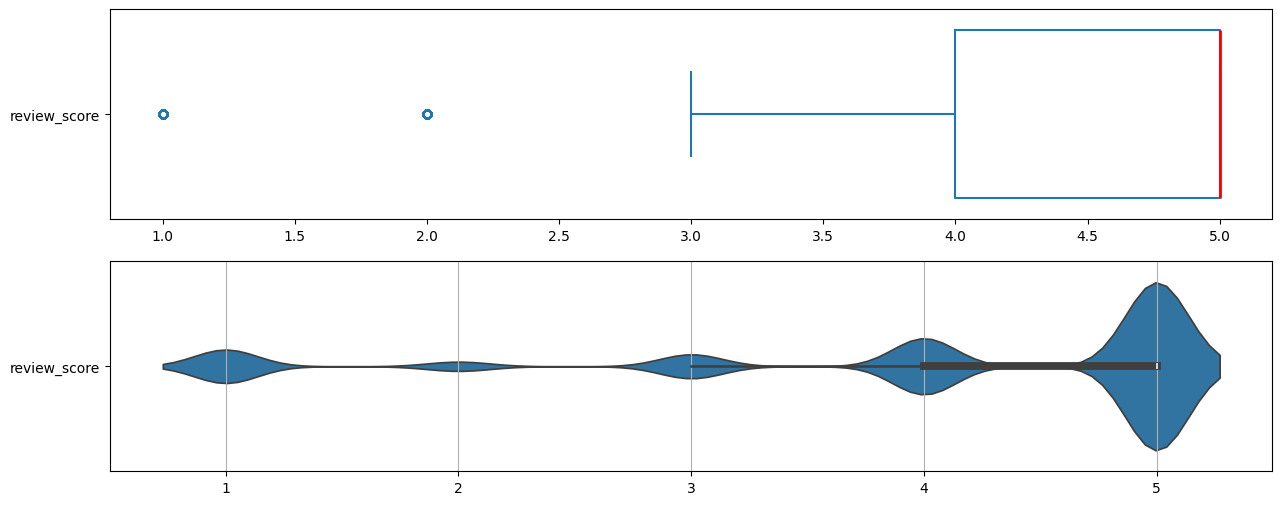

In [15]:
fig, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(15,6) )
plt.grid(True)
sea.boxplot(score   , orient='h', ax=ax[0], medianprops={"color": "r", "linewidth": 2},fill=False)
sea.violinplot(score, orient='h', ax=ax[1])
plt.show()

> Os dados estão mais concentrados no '4-5' 
> Existe outliers , contudo não irei remove-los pois usei para resolver as perguntas abaixo...

Vou verificar se tem correlacao a nota do produto e se a pessoa comentou ou não

In [16]:
from scipy.stats import pointbiserialr
reviews = order_reviews.select(['review_score','review_comment_title'])\
    .withColumn(
    'Comentarios', f.when(f.col('review_comment_title').isNotNull(),1)\
        .otherwise(0) 
    ).toPandas()

reviews[['review_score','Comentarios']].corr()

,review_score,Comentarios
review_score,1.000000,-0.040565
Comentarios,-0.040565,1.000000


> Não tem uma correlacão entre a nota e se o pessoal comentou ou não

Fazendo o intervalo de confiança para o review_score com uma amostra com seed=42 para verificar se o media populacional estara entre esse intervalo 

In [17]:
from scipy.stats import t

random = np.random.RandomState(seed=42)

# Definindo amostra
amostra = random.choice(score.values.reshape(1,-1)[0], size=1000)
# Desvio padrão amostral
S       = np.std(amostra)
# Media amostral
xbar    = np.mean(amostra)
# Tamanho da amostra
n       = len(amostra)

# t critico usando o scipy.stats
nConf = 95/100
alpha = (1 - nConf)/2
tc    = abs(t.ppf(alpha , n-1))


E = tc * (S/np.sqrt(n))

print('-> Intervalo de confiança')
print(f'   {xbar-E:.2f} < mu < {xbar+E:.2f}')
print(f'Media populacional é de :{score.mean().values[0]:.2f}')

-> Intervalo de confiança
   3.95 < mu < 4.12
Media populacional é de :4.09


> Com o intervalo de confiança de 95% com essa amostra  media esta entre 3.95 e 4.12 oq é verdade pois a media populacional e $\mu$ : 4.09

## order_items

In [18]:
VerificaValoresDuplicados(order_items)

,Quantidade de valores duplicados,%
order_id,13984,12.4137
order_item_id,112629,99.9814
product_id,79699,70.7492
seller_id,109555,97.2526
shipping_limit_date,19332,17.1611
price,106682,94.7022
freight_value,105651,93.7870


> Existe grande quantidade de valores duplicados nesse conj. de dados

In [19]:
VerificaValoresNulos('order_items',order_items)

Para o conjuto de dados Order_Items , com 112650 linhas


,Quantidade de valores Nulos,%
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0


In [20]:
priceItems = order_items.select(f.col('price')).toPandas()

In [21]:
priceItems.describe()

,price
count,112650.000000
mean,120.653739
std,183.633928
min,0.850000
25%,39.900000
50%,74.990000
75%,134.900000
max,6735.000000


In [22]:
np.var(priceItems.values),'Valores muito disperso'

(33721.12018434555, 'Valores muito disperso')

> Media: 120.653739 , Desvio Padrão:183.633928 (Os intervalos são muito altos )


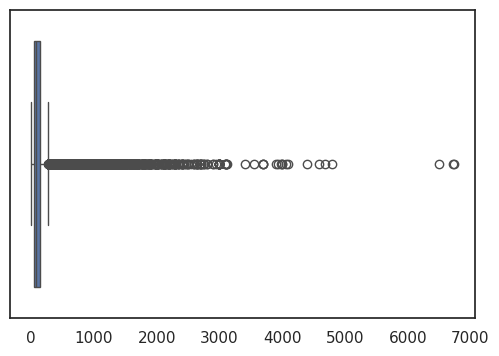

In [88]:
plt.figure(figsize=(6,4))
sea.boxplot(priceItems.values.reshape(1,-1)[0], orient='h')
plt.show()

> tem outliers

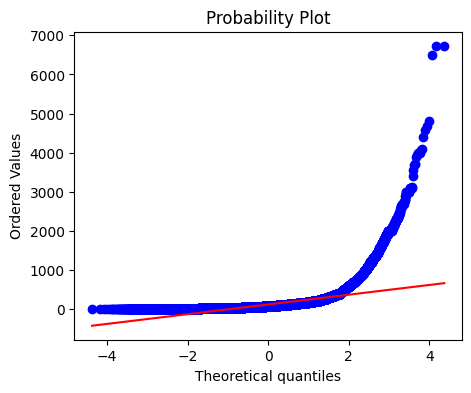

In [24]:
plt.figure(figsize=(5,4))
stats.probplot(x=priceItems.values.reshape(1,-1)[0], plot=plt, dist=stats.norm)
plt.show()

In [81]:
freteValor = order_items.select(f.col('freight_value')).toPandas()

In [82]:
display(freteValor.describe())
display('Variancia = '+str(np.var(freteValor.values)))

,freight_value
count,112650.000000
mean,19.990320
std,15.806405
min,0.000000
25%,13.080000
50%,16.260000
75%,21.150000
max,409.680000


'Variancia = 249.8402341932513'

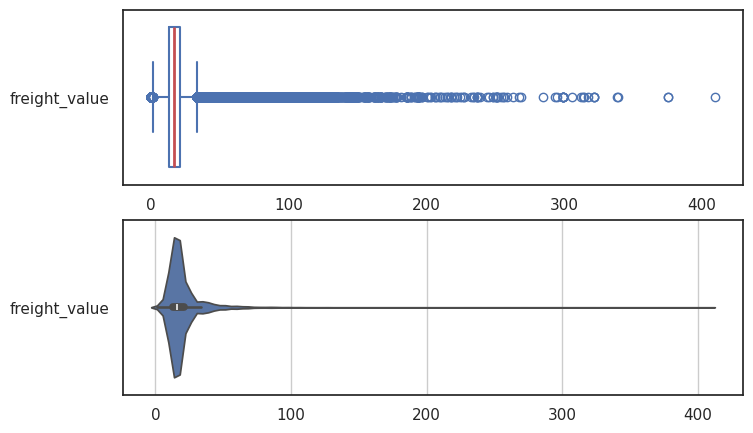

In [84]:
fig, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(8,5) )
plt.grid(True)
sea.boxplot( freteValor, orient='h', ax=ax[0], medianprops={"color": "r", "linewidth": 2},fill=False)
sea.violinplot(freteValor, orient='h', ax=ax[1])
plt.show()

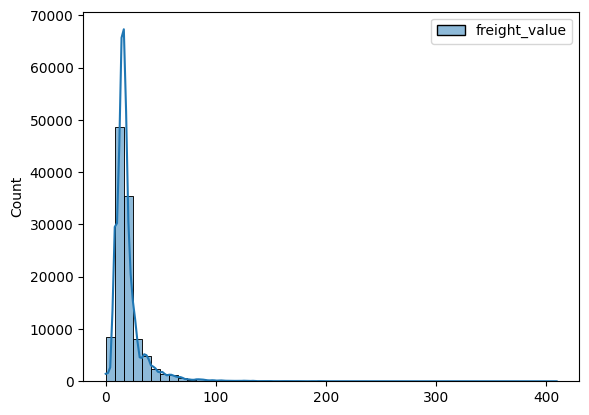

In [28]:
sea.histplot(freteValor, bins=50, kde=True)
plt.show()

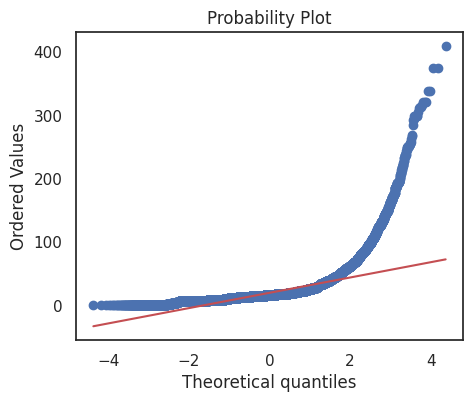

In [85]:
plt.figure(figsize=(5,4))
stats.probplot(x=freteValor.values.reshape(1,-1)[0], plot=plt, dist=stats.norm)
plt.show()

> Não seguem a normal

## payments

In [30]:
VerificaValoresDuplicados(payments)

,Quantidade de valores duplicados,%
order_id,4446,4.2797
payment_sequential,103857,99.9721
payment_type,103881,99.9952
payment_installments,103862,99.9769
payment_value,74809,72.0107


In [31]:
VerificaValoresNulos('payments',payments)

Para o conjuto de dados Payments , com 103886 linhas


,Quantidade de valores Nulos,%
order_id,0,0.0
payment_sequential,0,0.0
payment_type,0,0.0
payment_installments,0,0.0
payment_value,0,0.0


In [32]:
payments.select(f.col('payment_value')).toPandas().describe()

,payment_value
count,103886.000000
mean,154.100380
std,217.494064
min,0.000000
25%,56.790000
50%,100.000000
75%,171.837500
max,13664.080000


In [90]:
preços = payments.select(f.col('payment_value')).toPandas()

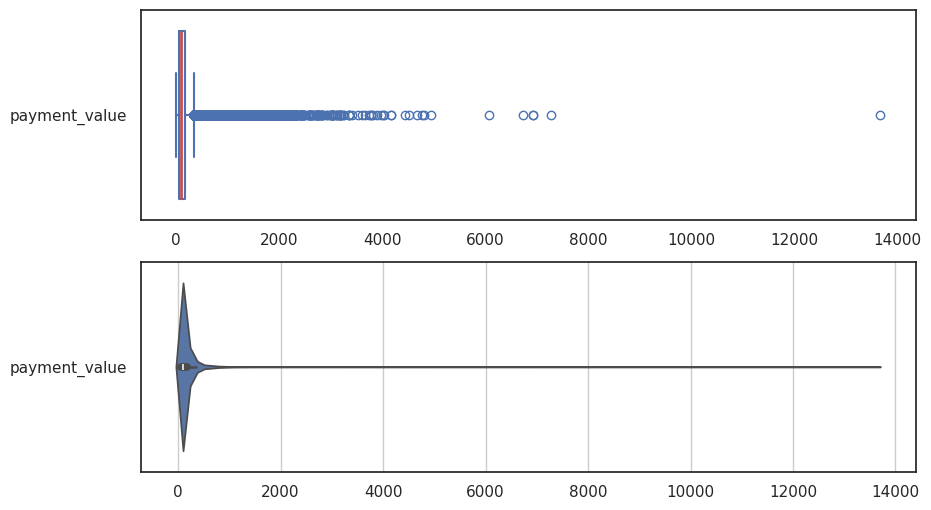

In [92]:
fig, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(10,6))
plt.grid(True)
sea.boxplot(preços, orient='h', ax=ax[0], medianprops={"color": "r", "linewidth": 2},fill=False)
sea.violinplot(preços, orient='h', ax=ax[1])
plt.show()

In [34]:
quartil3 = np.percentile(preços,75)
quartil1 = np.percentile(preços,25)

#limite superior, limite inferior
ls = quartil3 + 1.5*(quartil3-quartil1) 
li = quartil1 - 1.5*(quartil3-quartil1)
ls, li

(344.40875000000005, -115.78125000000003)

> Tem outliers, maioria dos valores estão concentrado entre [0 - 344.40875000000005]

In [35]:
di = (preços.loc[(preços['payment_value'] > li ) & (preços['payment_value'] < ls) ])\
    .values.reshape(1,-1)[0]

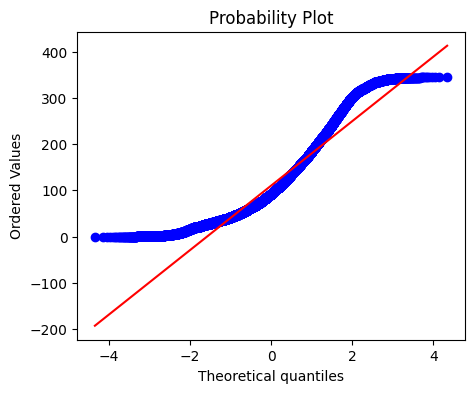

In [36]:
plt.figure(figsize=(5,4))
stats.probplot(x=di, plot=plt, dist='norm')
plt.show()

> Não seguem uma normal

In [37]:
from statsmodels.stats import diagnostic

print(diagnostic.lilliefors(di))

(0.09886785648904817, 0.0009999999999998899)


Abaixo verificando a quantidade de valores do tipo de pagamento a porcentagem e std de cada uma deles

In [38]:
newColumnOp = f.round(((f.col('Quantidade'))/payments.count())*100,3)

payments.select(f.col('payment_type').alias('Tipo de Pagamento'),
                f.col('payment_installments'))\
        .groupBy(f.col('Tipo de Pagamento'))\
            .agg(
                f.count(f.col('Tipo de Pagamento')).alias('Quantidade'),
                f.round( 
                        f.std( f.col('payment_installments') ),3
                    ).alias('Intervalo medio')
                )\
        .orderBy(f.col('Quantidade').desc())\
            .withColumn('%', newColumnOp).toPandas()

,Tipo de Pagamento,Quantidade,Intervalo medio,%
0,credit_card,76795,2.851,73.922
1,boleto,19784,0.000,19.044
2,voucher,5775,0.000,5.559
3,debit_card,1529,0.000,1.472
4,not_defined,3,0.000,0.003


> Maioria dos pagamentos efetuados foram no cartão de credito

In [39]:
parcelamento = payments.select(['payment_installments','payment_type'])\
                    .where(f.col('payment_type')=='credit_card')\
                        .toPandas()['payment_installments']
parcelamento.describe()

count    76795.000000
mean         3.507155
std          2.850990
min          0.000000
25%          1.000000
50%          3.000000
75%          5.000000
max         24.000000
Name: payment_installments, dtype: float64

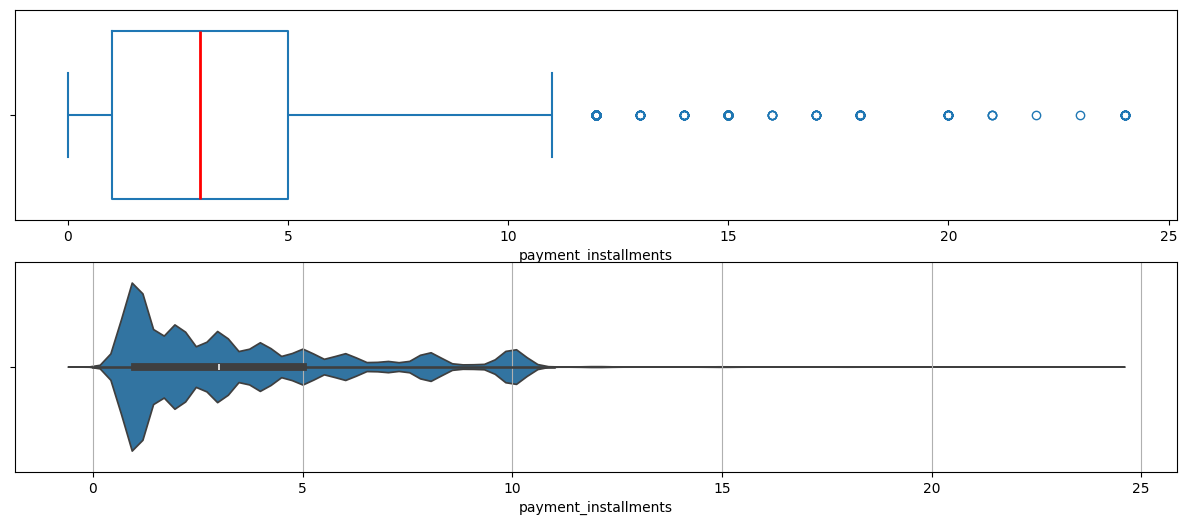

In [40]:
fig, ax = plt.subplots(nrows=2 ,ncols=1, figsize=(15,6))
plt.grid(True)
sea.boxplot(parcelamento, orient='h', ax=ax[0], medianprops={"color": "r", "linewidth": 2},fill=False)
sea.violinplot(parcelamento, orient='h', ax=ax[1])
plt.show()

> Tem outliers \
> Maior parte dos dados estão concentrados entre 1 e 5

### Outros datasets

In [41]:
VerificaValoresNulos('order_product', order_product)

Para o conjuto de dados Order_Product , com 32951 linhas


,Quantidade de valores Nulos,%
product_id,0,0.0000
product_category_name,610,1.8512
product_name_lenght,610,1.8512
product_description_lenght,610,1.8512
product_photos_qty,610,1.8512
product_weight_g,2,0.0061
product_length_cm,2,0.0061
product_height_cm,2,0.0061
product_width_cm,2,0.0061


In [42]:
VerificaValoresNulos('order_items',order_items)

Para o conjuto de dados Order_Items , com 112650 linhas


,Quantidade de valores Nulos,%
order_id,0,0.0
order_item_id,0,0.0
product_id,0,0.0
seller_id,0,0.0
shipping_limit_date,0,0.0
price,0,0.0
freight_value,0,0.0


In [43]:
VerificaValoresNulos('geolocation',geolocation)

Para o conjuto de dados Geolocation , com 1000163 linhas


,Quantidade de valores Nulos,%
geolocation_zip_code_prefix,0,0.0
geolocation_lat,0,0.0
geolocation_lng,0,0.0
geolocation_city,0,0.0
geolocation_state,0,0.0


In [44]:
VerificaValoresNulos('sellers',sellers)

Para o conjuto de dados Sellers , com 3095 linhas


,Quantidade de valores Nulos,%
seller_id,0,0.0
seller_zip_code_prefix,0,0.0
seller_city,0,0.0
seller_state,0,0.0


Reposta das perguntas abaixo

&nbsp;

## Resposta para perguntas

### Quais são categorias com maior e menor receita dos ultimos 12 meses?

**`query`**: serão as consultas SQL, depois passo Pandas(*.toPandas()*) ou utilizo o proprio Pyspark

In [45]:
query = 'SELECT min(order_approved_at) AS tempoMin, \
                max(order_approved_at) AS tempoMax  \
        FROM orders;'
display( spark.sql(query).toPandas() )

,tempoMin,tempoMax
0,2016-09-15 12:16:38,2018-09-03 17:40:06


> O data vão de 2016 a 2018

Usando **Sql Spark** para fazer as questões \
Fazendo o `INNER JOIN` nas repestivas tabelas abaixo e com o `order_status!=canceled` ,pois so será computado as vendas feitas(ou seja diferente de cancelado) assim consigo obter o valor real das Receitas de um produto, vender, estado.....
> Essa logica será feitas sobre as questões adiante que pedem `receitas` de algo

In [46]:
query = '''

SELECT product_category_name , SUM(payment_value) as Receita FROM order_items as o_i
    INNER JOIN order_product as o_p ON
        o_p.product_id = o_i.product_id
    INNER JOIN orders as or ON
        or.order_id = o_i.order_id
    INNER JOIN payments as pay ON
        pay.order_id = or.order_id
 
    WHERE order_status != 'canceled'       AND
        order_approved_at >= '2017-10-03' AND
        order_approved_at <= '2018-10-03' 
    GROUP BY product_category_name
    ORDER BY receita desc;
'''

In [47]:
data = spark.sql(query).toPandas()

Modificando a coluna `product_category_name` para torna-la mais legivel

In [48]:
# Tirar o `_` e colacando o ' ' (espaco vazio) usando o replace
data['product_category_name'] = data['product_category_name'].str.replace('_',' ')
# Deixando as primeiras letras de cada palavra maiuscula
data['product_category_name'] = data['product_category_name'].str.title()

Usarei seaborn e matplotlib para visualização pois ele renderiza no github, diferente do plotly

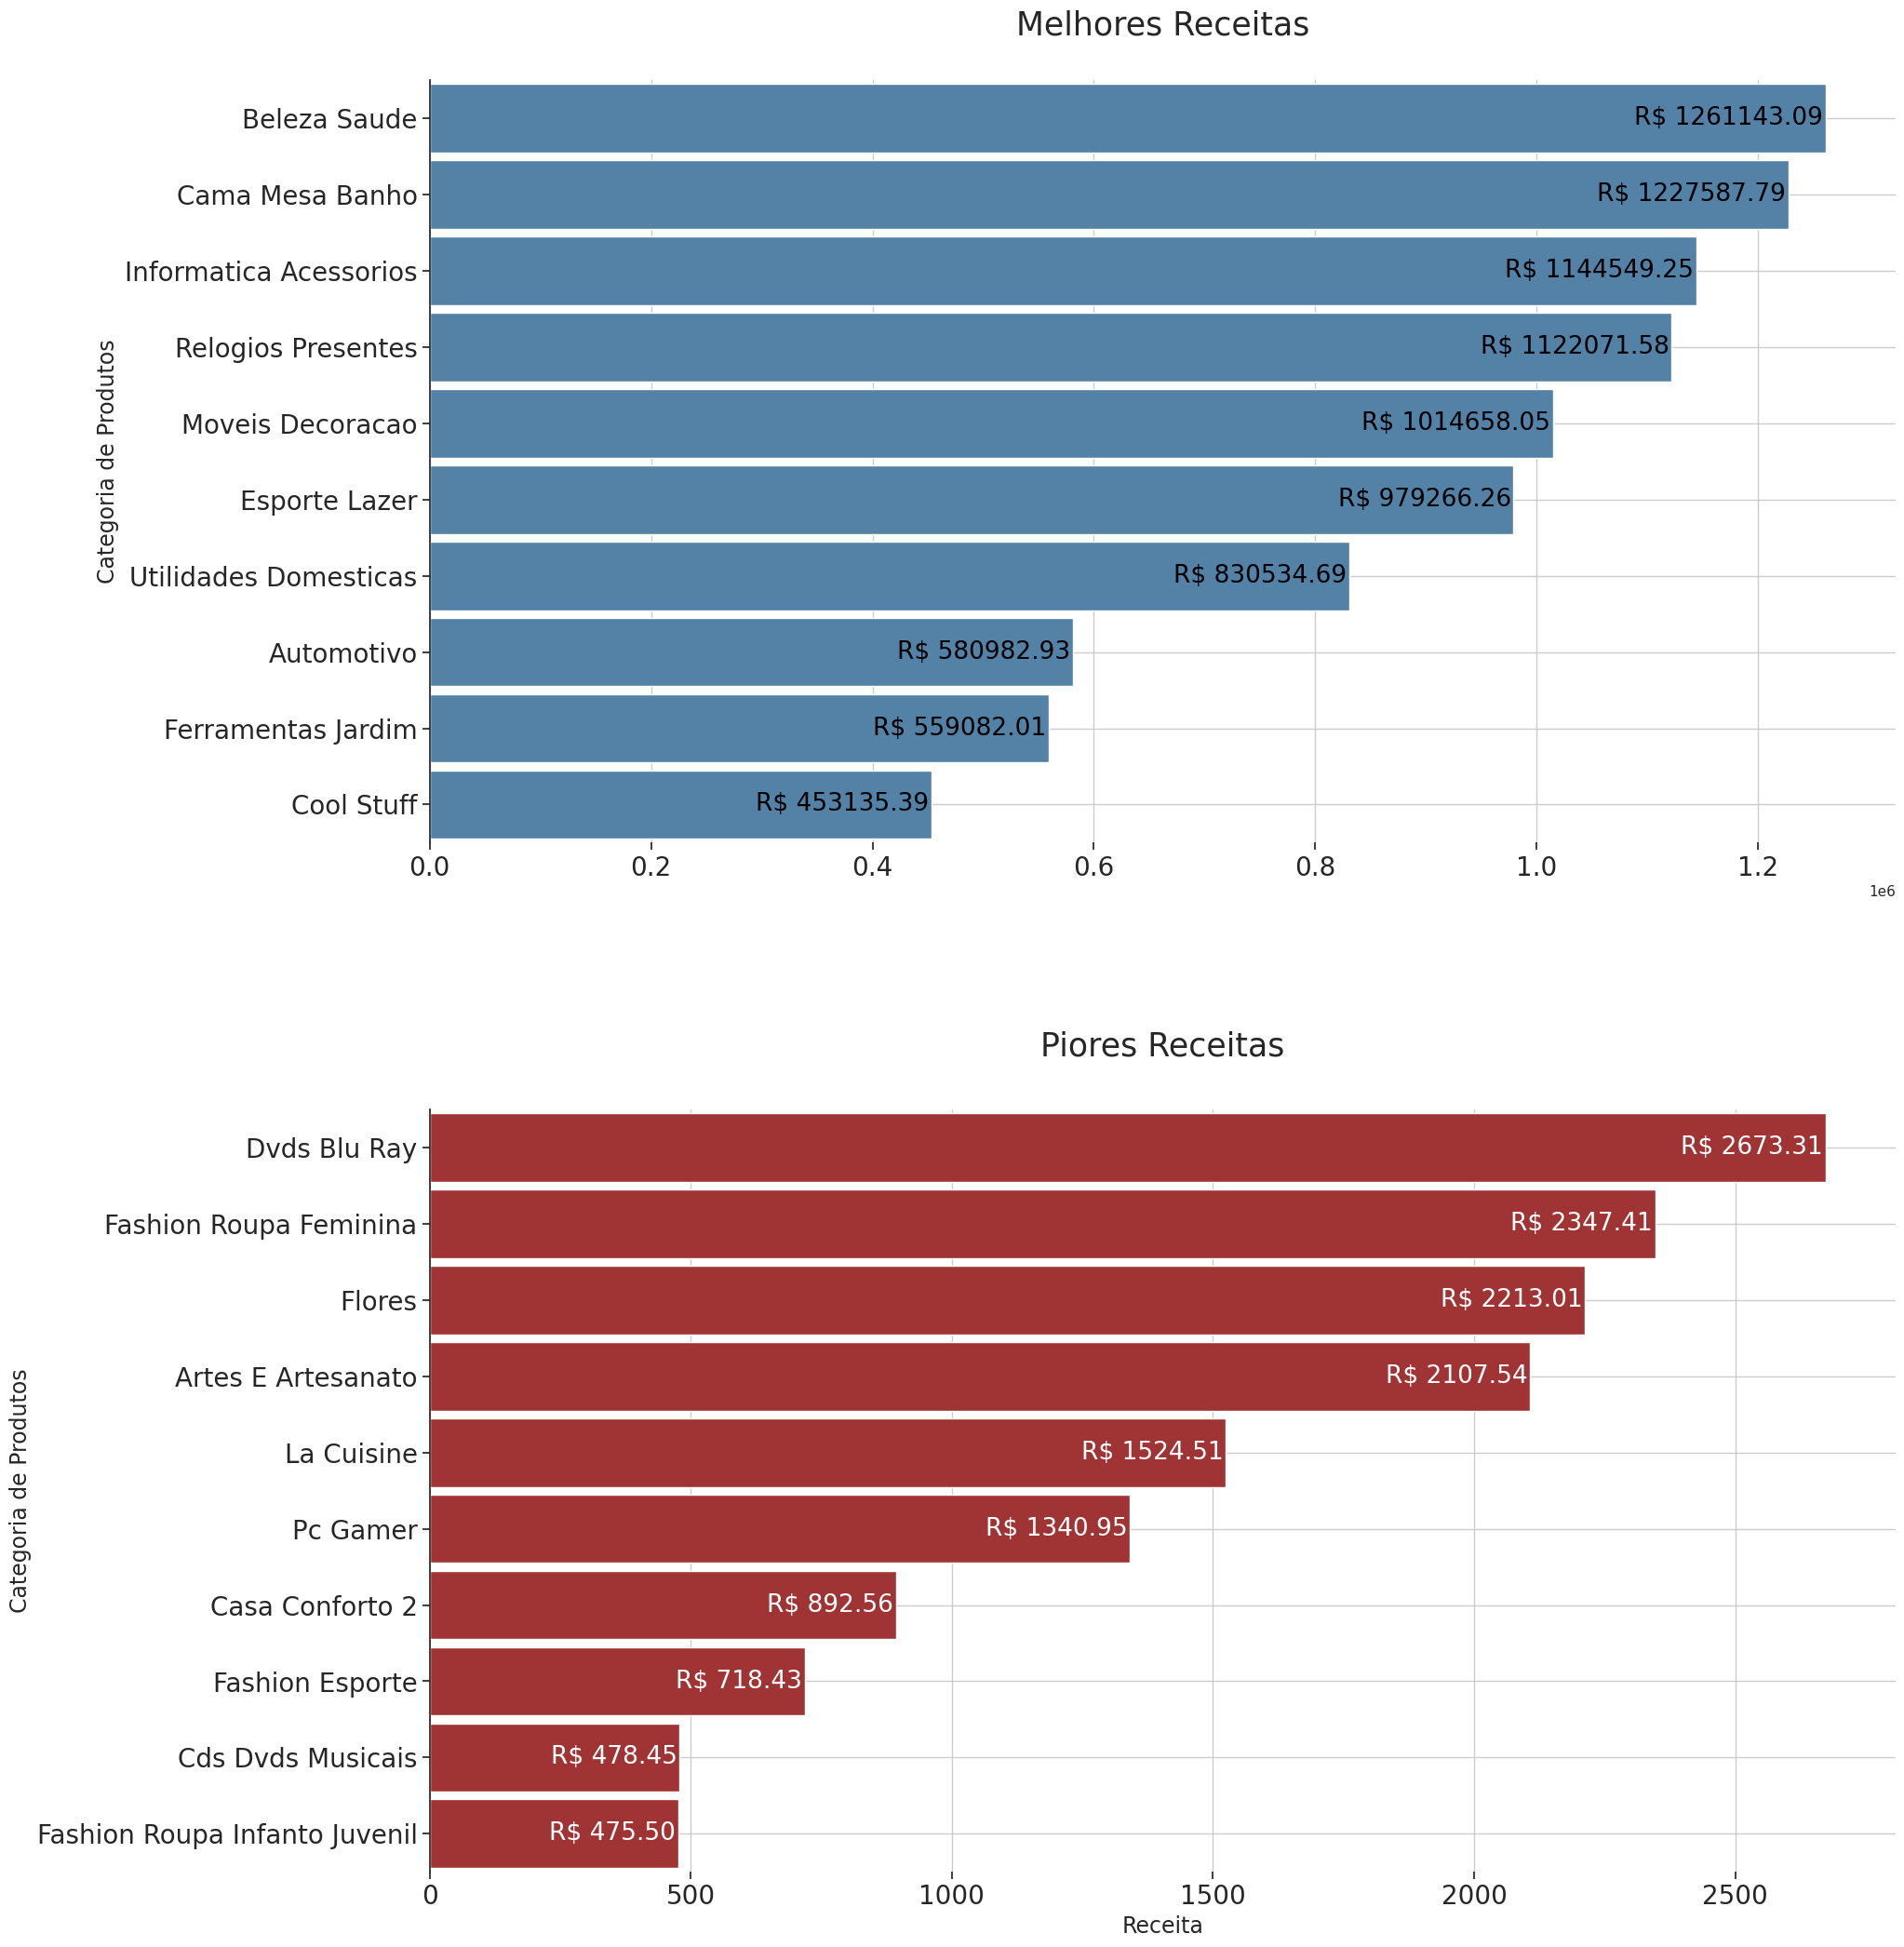

In [49]:
sea.set_theme(context='notebook',style='ticks')  # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=2,figsize=(18,25))
fig.subplots_adjust(hspace=0.35,right=1)        # Aumenta o espaço entre os graficos

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = data.iloc[0:10,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.9,
    palette= ['steelblue']*10 , ax = ax[0], legend=False
)

# Grafico 2 = Piores receitas
barPiores = sea.barplot(data=data.iloc[63:76,:], 
    y='product_category_name', x='Receita', hue='product_category_name',width=0.9,
    palette = ['firebrick']*10  , ax = ax[1], legend=False
)

#Colocar text nas barras do graphico fiz dessa forma para
#economizar o numero de linhas
for graph,ha in zip([barMelhores,barPiores],['black','white']):
    for p in graph.patches:
        if p.get_width() != 0:
            xy = (p.get_width(), p.get_y()+p.get_height()/2)
            graph.annotate("R$ %.2f" % p.get_width(),xy = xy, 
                xytext = (-2, 0), textcoords= 'offset points', 
                ha='right', va = "center" ,size=19, color=ha)

# Modificando Layout do grafico para deixar mais bonito
for axis in ax.flatten():
    axis.set_xlabel('')
    axis.set_ylabel('Categoria de Produtos',x=10,fontsize=17)
    axis.spines[['right','top','bottom']].set_visible(False)
    axis.tick_params('y', labelsize=20)
    axis.tick_params('x', labelsize=20)         
    axis.set_axisbelow(True)
    axis.grid(True)

#Modificando o Grafico 1
ax[0].set_title('Melhores Receitas',y=1.05,fontsize=25)

#Modificando o Grafico 2
ax[1].set_title('Piores Receitas',y=1.06,fontsize=25)       # Titulo 
ax[1].set_xlabel('Receita',fontsize=17)                     # Modificando eixo x
plt.show()

&nbsp;

### Top 10 maiores sellers (maior receita)?

Criação de uma nova coluna com o seller_id e o estado desse seller e a soma dos valores pagos,é feito a junção(INNER JOIN) nas respectivas tabelas abaixo escritas no `query` e uma condição que só é selecionado a status do pedido diferente de canceled

> Esse query será utilizado para resolução do top 10 melhores e piores, na primeira como eu quero os 10 melhores `query.format('desc')`(*decrescente*) no caso os piores `query.format('asc')` 

In [50]:
query = '''
SELECT (INITCAP(se.seller_id)|| ' - ' || se.seller_state) as seller ,
        ROUND(sum(payment_value),2) as receita FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        o_i.seller_id = se.seller_id
    INNER JOIN payments AS py ON
        py.order_id  = o_i.order_id
    INNER JOIN orders AS o_r ON
        o_r.order_id = py.order_id
    WHERE order_status != 'canceled'  

    GROUP BY seller
        ORDER BY receita {} limit 10; 
'''

In [51]:
melhorSeller = spark.sql(query.format('desc')).toPandas()

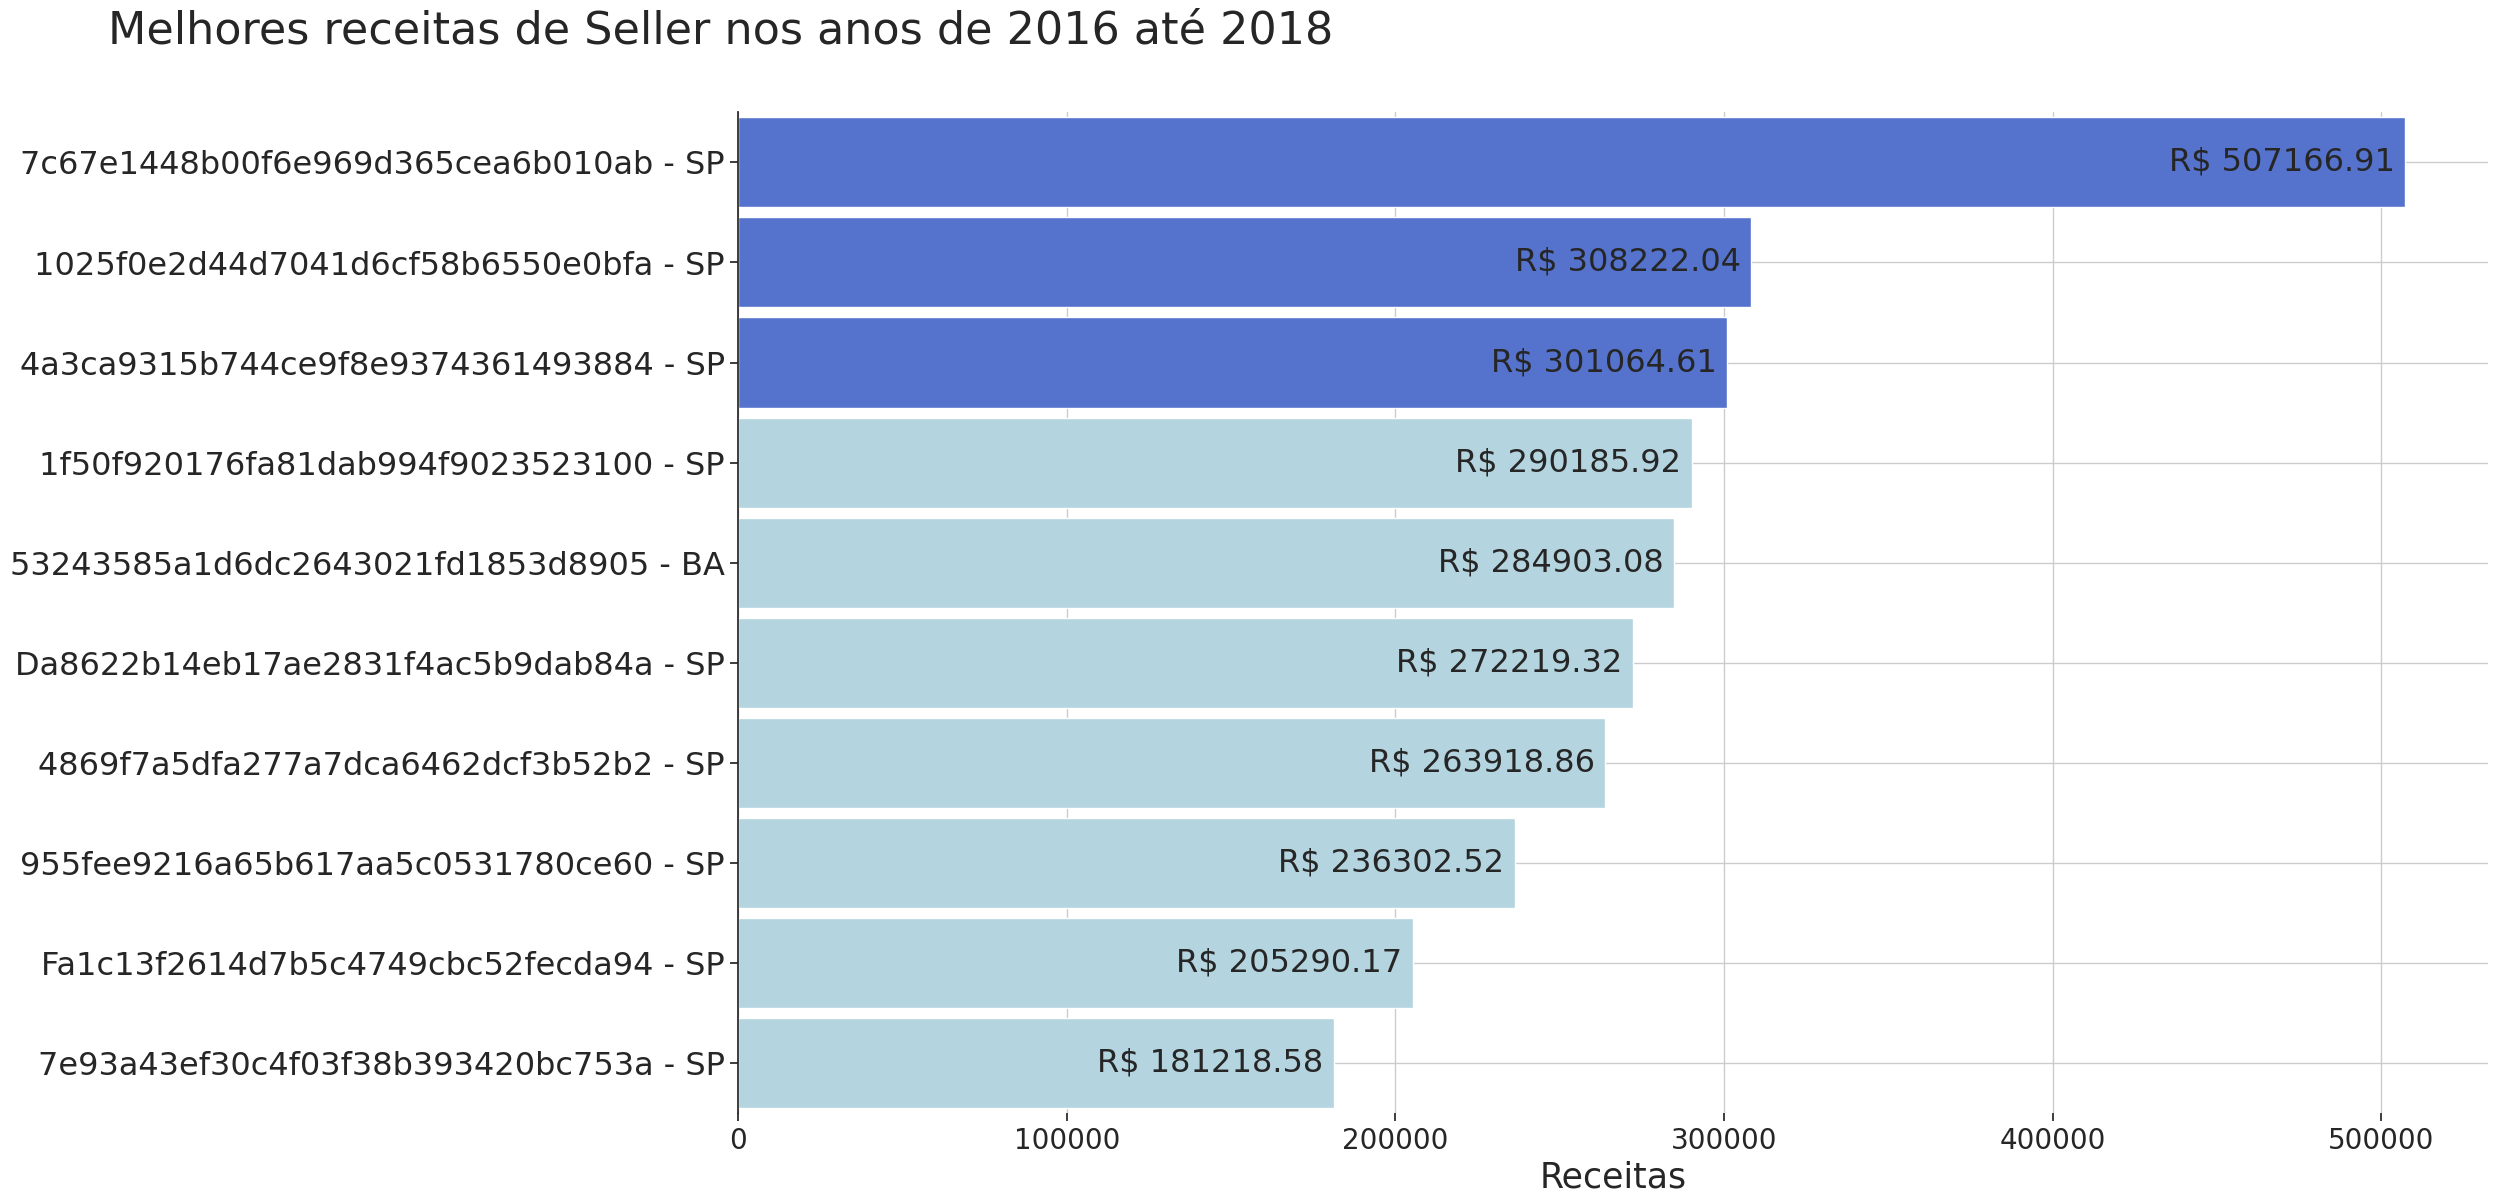

In [52]:
sea.set_theme(style="ticks",context='notebook')                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(20,13))
fig.subplots_adjust(hspace=0.25,right=1)    # Aumenta o espaço entre os graficos
pallete = ['lightblue']*7 + ['royalblue']*3

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = melhorSeller, palette=pallete[::-1],
    y='seller', x='receita', hue='seller', width=0.9, ax = ax, legend=False)

#Modificando o Grafico 1
ax.set_title('Melhores receitas de Seller nos anos de 2016 até 2018', 
              y=1.06, fontsize=32, loc='left', x=-0.36)
ax.set_ylabel('')
ax.set_xlabel('Receitas',fontsize=25)
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=23)
ax.tick_params('x', labelsize=20)         
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("R$ %.2f" % p.get_width())+' ',  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=23)

&nbsp;

### Top 10 piores sellers?

Reutilizando o query acima, agora são os 10 piores `query.format('asc')`(*crescente*)

In [53]:
piorSeller = spark.sql(query.format('asc')).toPandas()[::-1]

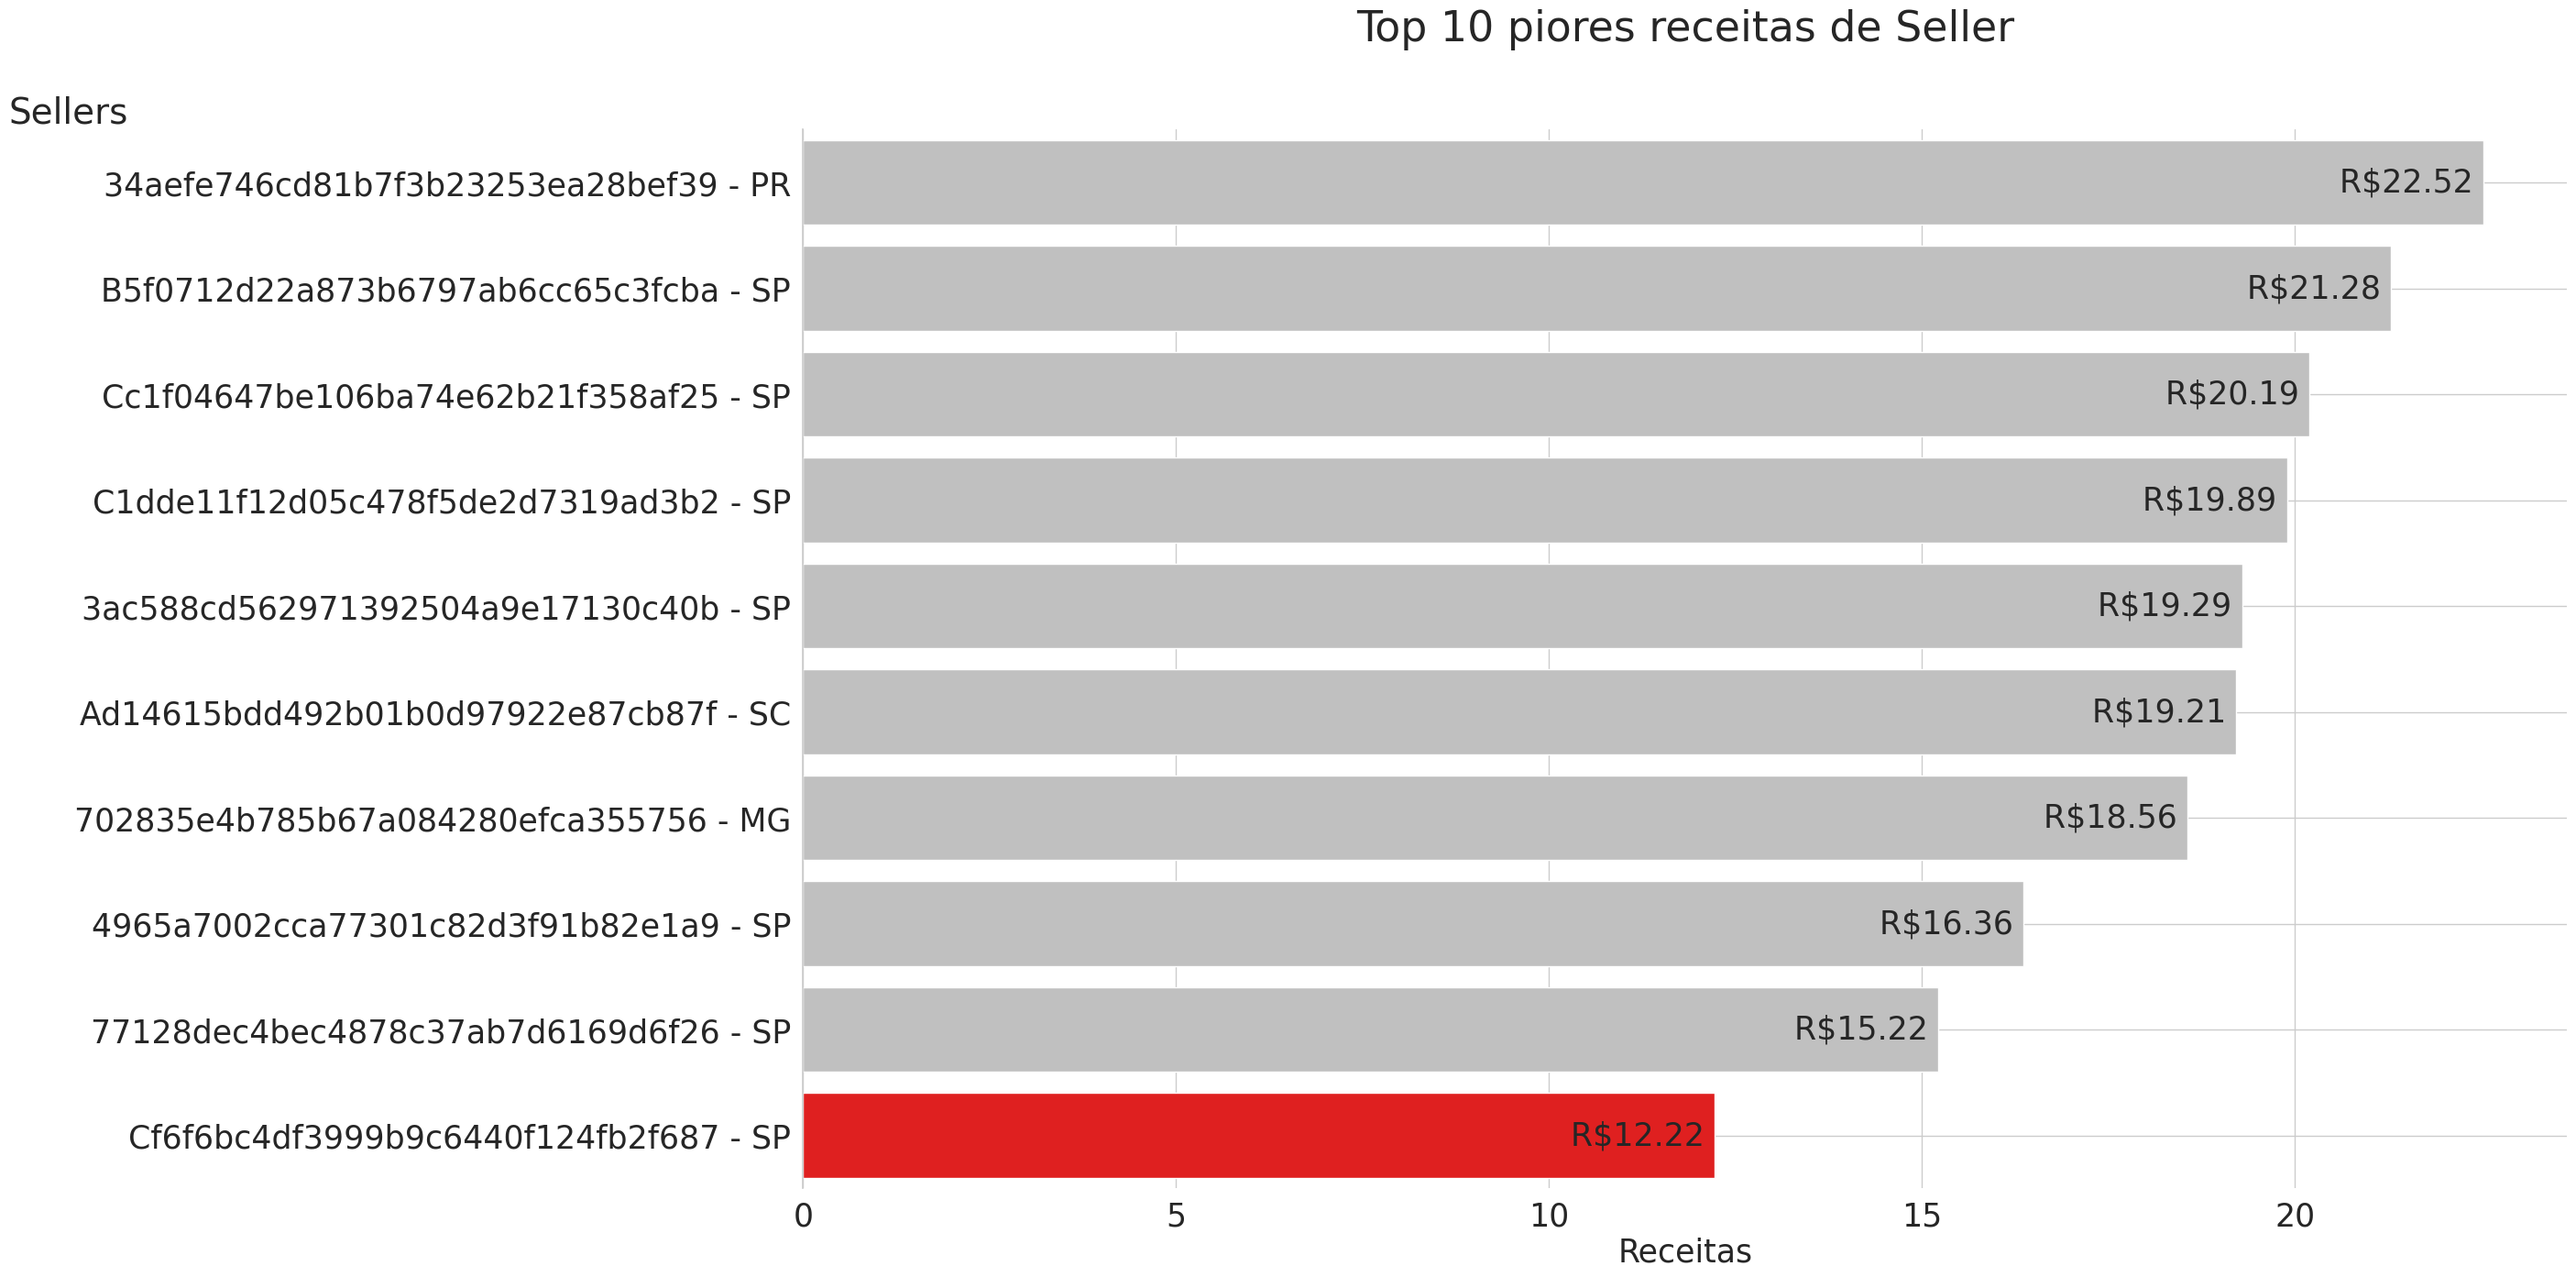

In [54]:
sea.set_theme(style="whitegrid", context='notebook')# Definindo estilo
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(22,15))
fig.subplots_adjust(hspace=0.25, right=1)    # Aumenta o espaço entre os graficos
pallete = (['silver']*9+['red'])

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = piorSeller.iloc[0:10,:], palette=pallete,
    y='seller', x='receita', hue='seller', width=0.8, ax = ax, legend=False)

#Modificando o Grafico 1
ax.set_title('Top 10 piores receitas de Seller', 
              y=1.06, fontsize=33, pad=20)
ax.set_ylabel('Sellers', y=1, x=20, fontsize=28, rotation='horizontal')
ax.set_xlabel('Receitas',fontsize=25)
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=25)
ax.tick_params('x', labelsize=25)         
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das receitas nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("R$%.2f" % p.get_width())+' ',  
        xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=25)

&nbsp;

### Existem sellers que vendem o mesmo produto? se sim quais são? Qual a variação de preço praticada entre os sellers?

Usarei o pandas para fazer o group by pois fica melhor de visualizar a tabela ou ela organiza melhor quando usa duas colunas para essa operação

In [55]:
query = '''
SELECT se.seller_id, product_category_name,price FROM sellers AS se
    INNER JOIN order_items AS o_i ON
        se.seller_id = o_i.seller_id
    INNER JOIN order_product AS op ON
        op.product_id = o_i.product_id
'''

In [56]:
data = spark.sql(query).na.drop().toPandas()

In [57]:
data = data.groupby(by=['seller_id','product_category_name'])['price'].mean().reset_index()

In [58]:
def VerificaVariancao(dataset:pd.DataFrame):
    sellers = dataset['seller_id'].unique()
    dicionario = {
        'sellers':[], 'categoria':[], 'Variação':[]
    }

    for enum, seller_i in enumerate(sellers):
        df1 = dataset.loc[dataset['seller_id']==seller_i]
        categorias = df1['product_category_name'].unique()
        for seller_j in sellers[enum+1:]:
            df2 = dataset.loc[ 
                               ( dataset['seller_id']==seller_j                   ) &
                               ( dataset['product_category_name'].isin(categorias))
                               ]
            if (len(df2)!= 0):
                for categoria in df2['product_category_name'].unique():
                    df_i_1 = df1.loc[df1['product_category_name']==categoria]
                    df_i_2 = df2.loc[df2['product_category_name']==categoria]
                    
                    dicionario['sellers' ].append(seller_i + '-' + seller_j)
                    dicionario['categoria'].append(categoria)
                    dicionario['Variação'].append(
                        abs(df_i_1['price'].values[0] - df_i_2['price'].values[0])
                    )

        if enum == 4:break
    return pd.DataFrame(dicionario)

&nbsp;

### Ouve inflação no preço dos produtos ao passar do Tempo? Se ouve, que quanto foi a variação desta inflação em '%' e em 'R$'? 
* Sim houve inflação, serão selecionado só 4 produtos para visualizar a inflação pois são muitos produtos e utilizar todos não fica boa a visualização
    * Tambem ouve deflação

In [59]:
query = '''
SELECT product_category_name AS produto, 
        YEAR(oi.shipping_limit_date) AS Anos, ROUND(MEAN(price),2) AS media_preco  
    FROM order_product AS op
        INNER JOIN order_items AS oi ON
            op.product_id = oi.product_id 
        
    WHERE product_category_name IS NOT NULL AND 
          YEAR(oi.shipping_limit_date) != 2020  
    
    GROUP BY product_category_name, YEAR(oi.shipping_limit_date)
        ORDER BY YEAR(oi.shipping_limit_date);
'''

In [60]:
inflacao = spark.sql(query).toPandas()

A função `inflacaoData` irá calcular a inflação em porcentagem e em reais 
* ela recebe como paremetro um dataframe e retorna dataframe com a respota 

In [61]:
def inflacaoData(data:pd.DataFrame):
    dicionario = dict(porcentagem = [], produtos = [], ano = [], reais=[])
    produto_cat = data['produto'].unique()
    
    for column in produto_cat[[0,17,1,12]]:
        selecao = data.loc[ data['produto'] == column ]
        preco   = selecao['media_preco'].values.tolist()
        
        for i in range(1, len(preco)):
            inflacao = ((preco[i] / preco[i-1])/preco[i-1])*100
            reais    = preco[i-1]*(inflacao/100)
            dicionario['produtos'].append(column)
            dicionario['ano'].append(selecao['Anos'].iloc[i])
            dicionario['porcentagem'].append(inflacao)
            dicionario['reais'].append(reais)

    return pd.DataFrame(dicionario)

Modificando a string pra deixa-la mais legivel

In [62]:
inflacaoDf = inflacaoData(inflacao)
# Tirar o `_` e colacando o ' ' (espaco vazio) usando o replace
inflacaoDf['produtos'] = inflacaoDf['produtos'].str.replace('_',' ')
# Deixando as primeiras letras de cada palavra maiuscula
inflacaoDf['produtos'] = inflacaoDf['produtos'].str.title()

criando um grafico line com seaborn

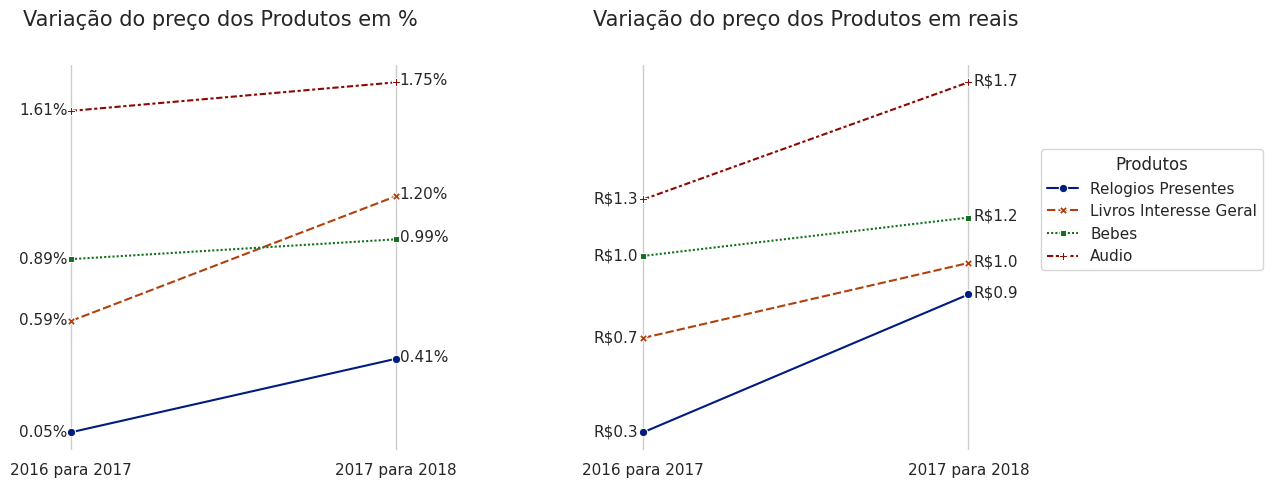

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
fig.subplots_adjust(wspace=0.6)
sea.set_theme(context='notebook',style='ticks')

columns = ['porcentagem','reais']
for column, axis in zip(columns, ax.flatten()):
    legends = (True if column=='reais' else False)
    
    sea.lineplot(
        inflacaoDf, x='ano', y=column, ax=axis, legend= legends,
        hue = 'produtos', style = "produtos", markers=True, palette=sea.color_palette('dark', n_colors=4)
    )

    axis.set_ylabel('')
    axis.set_xlabel('')
    axis.spines[['right','top','bottom','left']].set_visible(False)
    axis.grid(True,axis='x')
    axis.set_xticks([2017,2018],labels=['2016 para 2017','2017 para 2018'])
    axis.set_yticks([])
    
    # Colocanco anotação no lineplot
    for index, row in inflacaoDf.iterrows():
        # compressao das condições para fazer tudo em uma linha  
        char = (
            f'{row[column]:.2f}%' if (column == 'porcentagem') else f'R${row[column]:.1f}'
            )

        if row['ano']==2017:
            axis.annotate(char, (row['ano'], row[column]), textcoords="offset points", 
                            xytext=(-20,-3), ha='center',size=11)
        else:
            axis.annotate(char, (row['ano'], row[column]), textcoords="offset points", 
                           xytext=(20,-2), ha='center', size=11)
            
ax[0].set_title('Variação do preço dos Produtos em %    ', size=15, y=1.08)
ax[1].set_title('Variação do preço dos Produtos em reais', size=15, y=1.08)
ax[1].legend(bbox_to_anchor=(0,0.8,1.8,0)).set_title('Produtos')
plt.show()

&nbsp;

### Top melhores 10 Seller com review positiva

In [64]:
categorico = ['Péssimo','Ruim','Neutro','Bom','Excelente']

> **1**=`Péssimo`  **2**=`Ruim` **3**=`Neutro` **4**=`Bom` **5**=`Excelente`

Essa seleção feita no sql sera utilizada para responder top 10 melhores seller e 10 piores seller

* Mundando os valores de review_score para categorico
* E fazendo a junção das respectivas tabelas abaixo

In [65]:
query = f'''
SELECT (se.seller_id ||'-'||se.seller_state) AS Seller ,o_r.review_cat 
    FROM ( SELECT order_id,
                    CASE
                        WHEN review_score = 1 THEN '{categorico[0]}'
                        WHEN review_score = 2 THEN '{categorico[1]}'
                        WHEN review_score = 3 THEN '{categorico[2]}'
                        WHEN review_score = 4 THEN '{categorico[3]}'
                        WHEN review_score = 5 THEN '{categorico[4]}'
                    ELSE NULL
                        END AS review_cat
                FROM order_reviews 
            ) AS o_r

    INNER JOIN orders AS od ON
        od.order_id = o_r.order_id
    INNER JOIN order_items AS oi ON
        oi.order_id = od.order_id
    INNER JOIN sellers AS se ON
        se.seller_id = oi.seller_id

    WHERE order_status != 'canceled';
'''

In [66]:
dataMelhorPior = spark.sql(query)

Selecionando as reviews que são Bom & excelente e fazendo o agrupamento em relação ao seller utilizando o pyspark

In [67]:
melhor = dataMelhorPior\
    .where(
        (f.col('review_cat')==categorico[3]) |
        (f.col('review_cat')==categorico[4])
    )\
    .groupBy(f.col('seller'))\
        .agg( f.count('review_cat').alias('Reviews Positivas') )\
    .orderBy(f.col('Reviews Positivas').desc())\
        .limit(10).toPandas()

* `ax.xaxis.set_label_position('top')`: estou movendo o xlabel para cima 
* `ax.tick_params('x', bottom=False, top=False, labelbottom=False)`: deixa o eixo x não visivel 

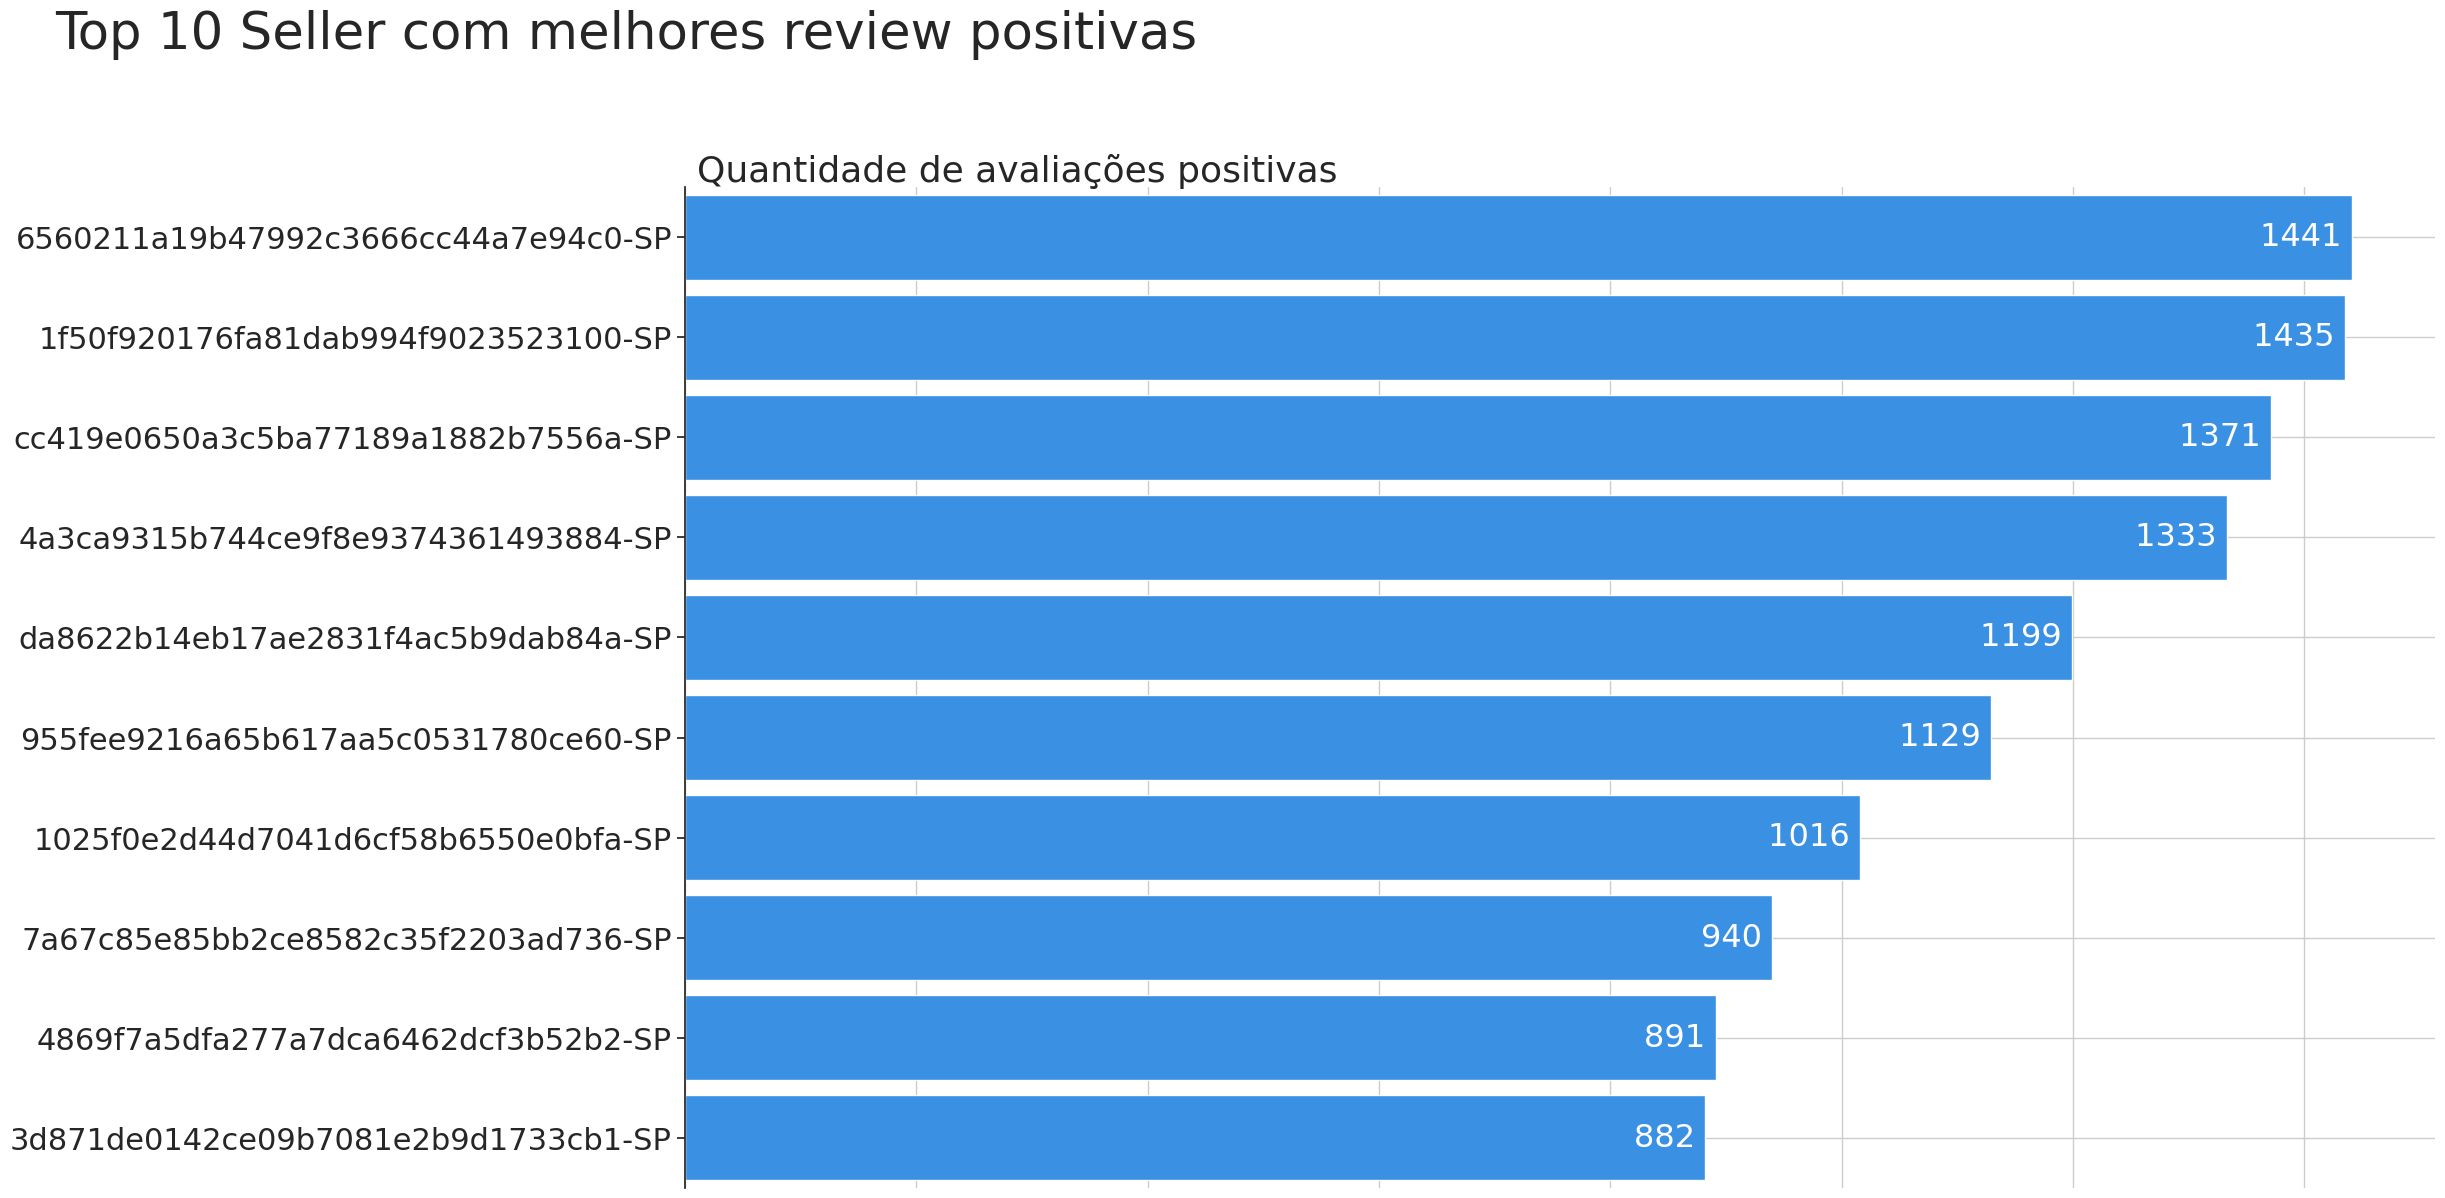

In [68]:
sea.set_theme(style='ticks',context='notebook')                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(20,13))
fig.subplots_adjust(hspace=0.25,right=1)    # Aumenta o espaço entre os graficos
pallete = ['dodgerblue']*10

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = melhor, palette=pallete[::-1],
    y='seller', x='Reviews Positivas', hue='seller', width=0.85, ax = ax, legend=False)

#Modificando o Grafico 1
ax.set_title('Top 10 Seller com melhores review positivas', y=1.13, fontsize=37, loc='left', x=-0.36)
ax.set_ylabel('')
ax.set_xlabel('Quantidade de avaliações positivas',fontsize=26, x=0.19, y=.2)
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=22)
ax.tick_params('x', bottom=False, top=False, labelbottom=False)  
ax.xaxis.set_label_position('top')
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das quantidade de review positiva nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.0f" % p.get_width())+' ',  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=23,color='white')

&nbsp;

### Top 10 piores seller com piores reviews

Selecionando as reviews que são Bom & excelente e fazendo o agrupamento em relação ao seller utilizando o pyspark

In [69]:
pior = dataMelhorPior\
    .where(
        (f.col('review_cat')==categorico[0]) |
        (f.col('review_cat')==categorico[1])
    )\
    .groupBy(f.col('seller'))\
        .agg( f.count('review_cat').alias('Reviews Negativas') )\
    .orderBy(f.col('Reviews Negativas').desc())\
        .limit(10).toPandas()

criando o grafico com o seaborn

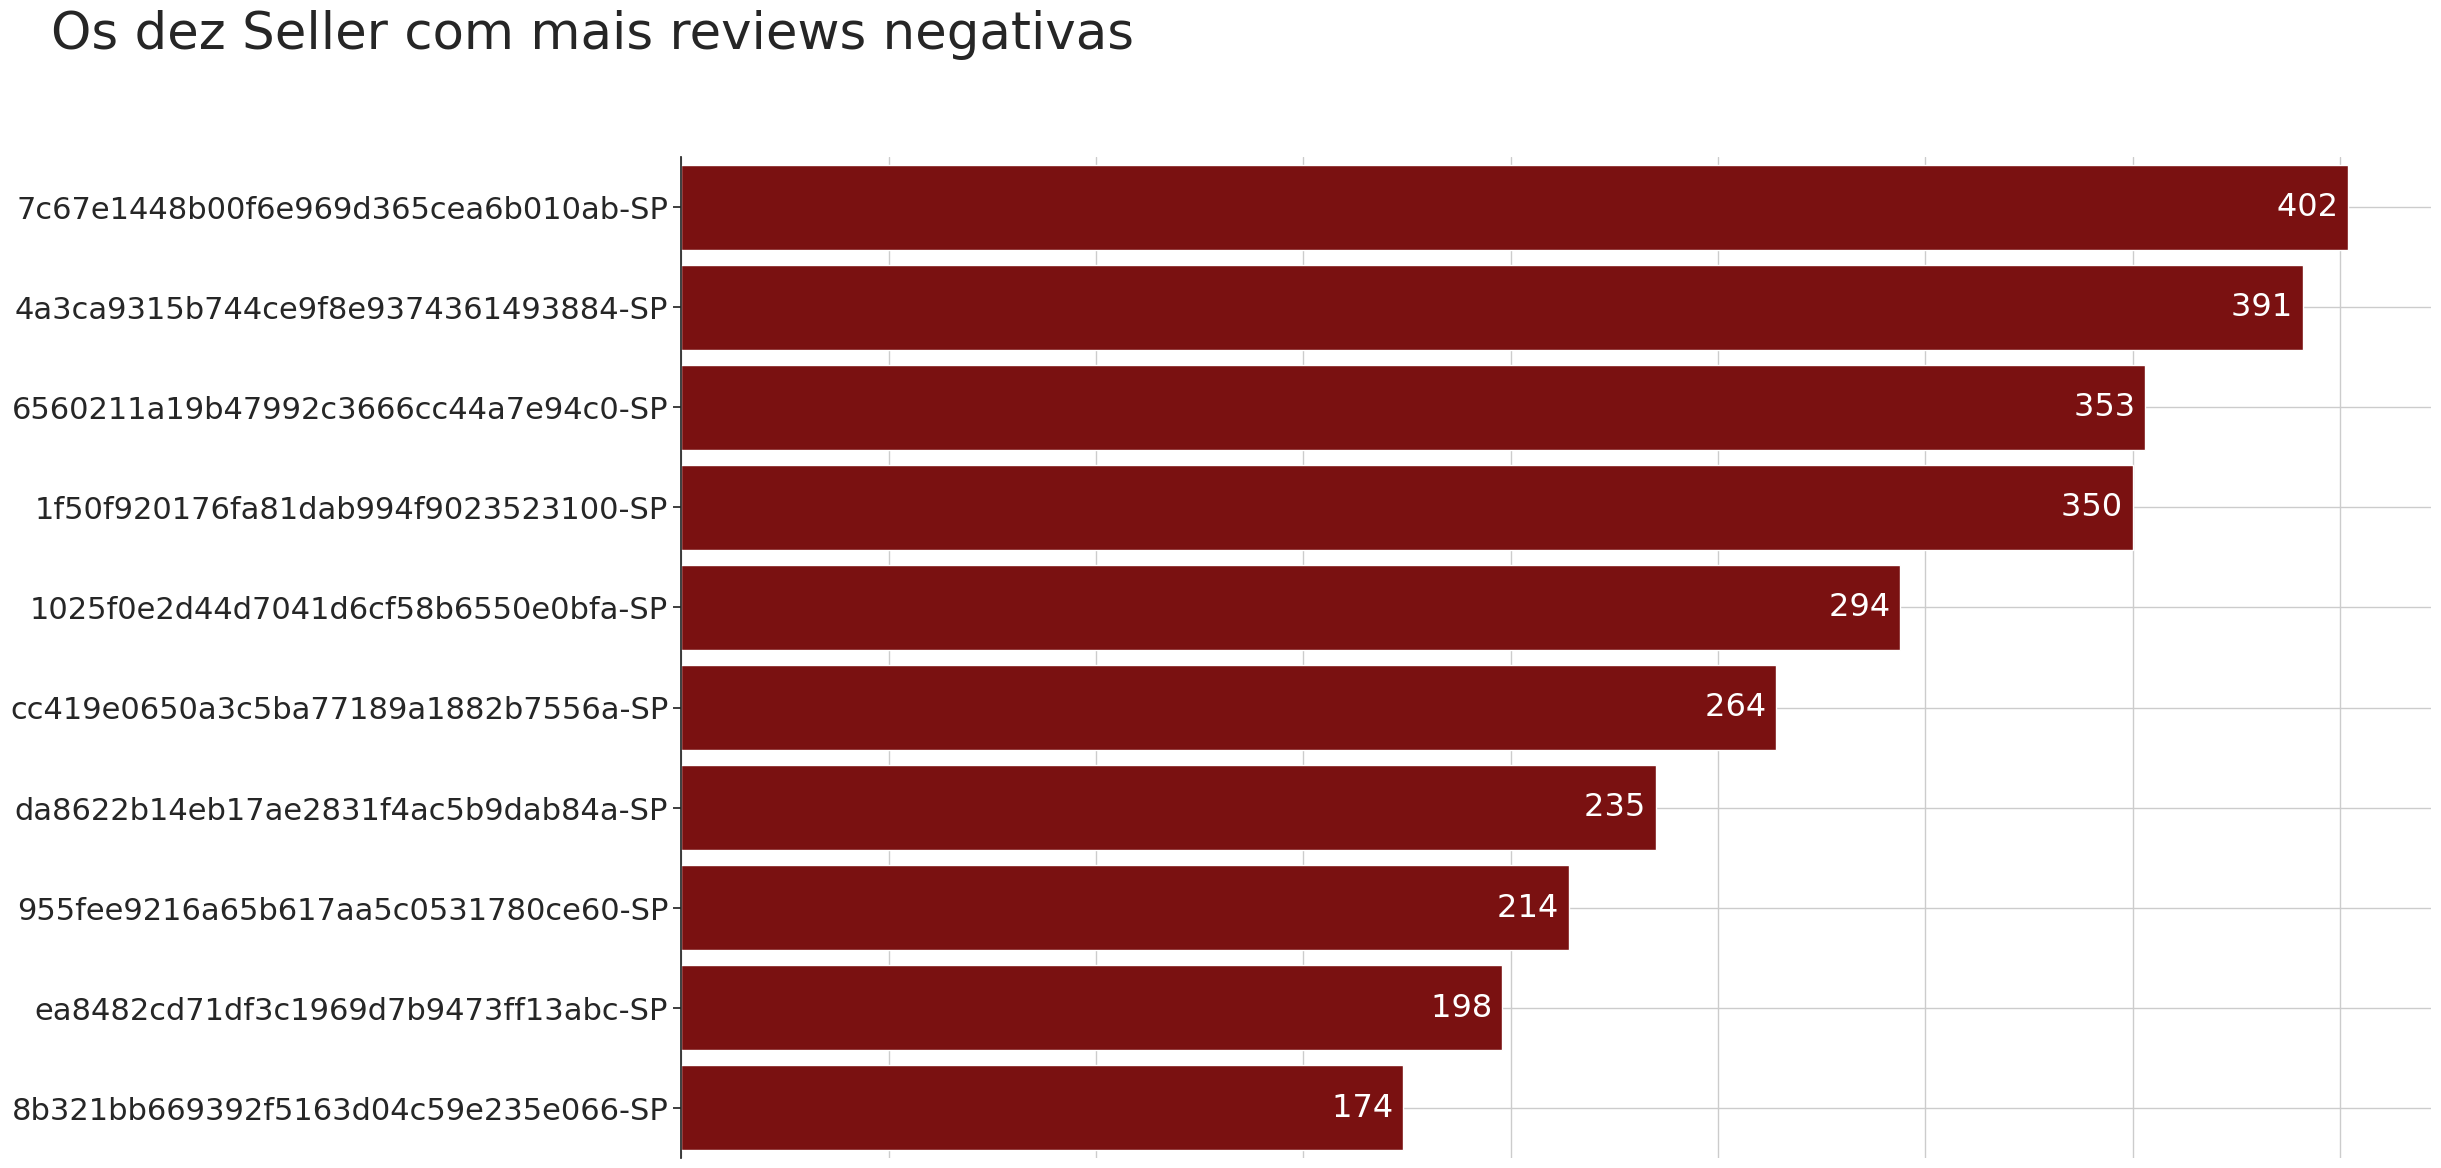

In [70]:
sea.set_theme(style='ticks',context='notebook')                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(20,13))
fig.subplots_adjust(hspace=0.25,right=1)    # Aumenta o espaço entre os graficos
pallete = ['darkred']*10

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = pior, palette=pallete[::-1],
    y='seller', x='Reviews Negativas', hue='seller', width=0.85, ax = ax, legend=False)

#Modificando o Grafico 1
ax.set_title( 'Os dez Seller com mais reviews negativas', y=1.10, fontsize=37, loc='left', x=-0.36)
ax.set_ylabel('')
ax.set_xlabel('')
ax.spines[['right','top','bottom']].set_visible(False)
ax.tick_params('y', labelsize=22)
ax.tick_params('x', bottom=False, top=False, labelbottom=False)  
ax.xaxis.set_label_position('top')
ax.set_axisbelow(True)
ax.grid(True)

# Colocando o valor das quantidade de review positiva nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("%.0f" % p.get_width())+' ',  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=23,color='white')

&nbsp;

### Existe relação entre a quantidade de vendas e a quantidade de review para os sellers? É possivel identificar aumento ou queda na venda de um seller com base nas avaliações do que já foi vendido no passado?

* Será selecionado o seller com maior receita para fazer essa questão
    * Seller = `7c67e1448b00f6e969d365cea6b010ab` | SP
    * Seller = `1025f0e2d44d7041d6cf58b6550e0bfa` | SP

In [71]:
query = '''
SELECT  CONCAT(month(order_approved_at), '-', year(order_approved_at)) AS mes_ano_aprovacao_pedido, 
        COUNT(review_score)   AS quantidade_reviews,
        COUNT(payment_value) AS quantidade_de_vendas 
    FROM sellers AS se
        INNER JOIN order_items AS o_i ON
            se.seller_id = o_i.seller_id
        INNER JOIN payments AS py ON
            o_i.order_id  = py.order_id
        LEFT JOIN orders AS o_r ON
            o_r.order_id = py.order_id
        LEFT JOIN order_reviews AS o_re ON
            o_r.order_id = o_re.order_id

        WHERE order_status != 'canceled'                         AND
              {}
              order_approved_at IS NOT NULL

        GROUP BY  
            month(order_approved_at), year(order_approved_at)
        ORDER BY  
            year(order_approved_at), month(order_approved_at);
'''

Para um seller especifico

In [72]:
quantidade = spark.sql(query.format("se.seller_id = '1025f0e2d44d7041d6cf58b6550e0bfa'  AND")).toPandas()

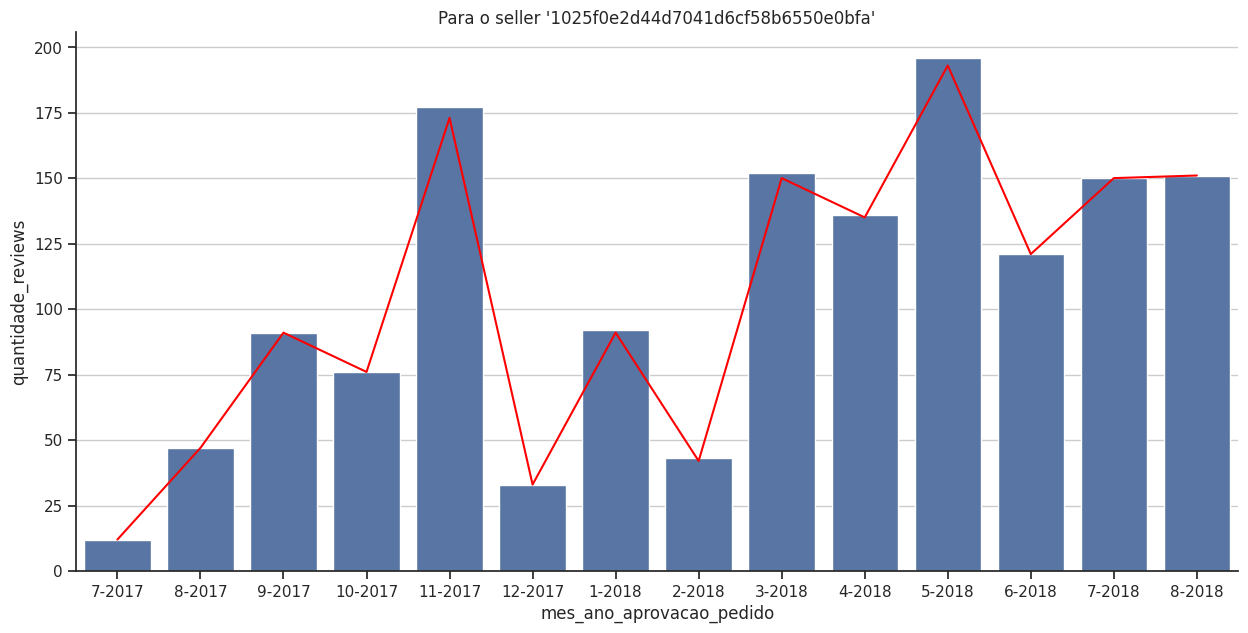

In [73]:
plt.figure(figsize=(15,7))
plt.title("Para o seller '1025f0e2d44d7041d6cf58b6550e0bfa'")
sea.lineplot(quantidade, x='mes_ano_aprovacao_pedido', y='quantidade_reviews', color='red', markers=True)
sea.barplot(quantidade, x='mes_ano_aprovacao_pedido', y='quantidade_de_vendas')
plt.gca().spines[['top','right']].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(True, axis='y')
plt.show()

In [74]:
print("Para o seller '1025f0e2d44d7041d6cf58b6550e0bfa'")
quantidade.iloc[:,1:].corr()

Para o seller '1025f0e2d44d7041d6cf58b6550e0bfa'


,quantidade_reviews,quantidade_de_vendas
quantidade_reviews,1.000000,0.999843
quantidade_de_vendas,0.999843,1.000000


Para os os seller 

In [75]:
todosSeller = spark.sql(query.format('\t')).toPandas()

In [76]:
print("Para todos os seller ")
todosSeller.iloc[:,1:].corr()

Para todos os seller 


,quantidade_reviews,quantidade_de_vendas
quantidade_reviews,1.000000,0.999993
quantidade_de_vendas,0.999993,1.000000


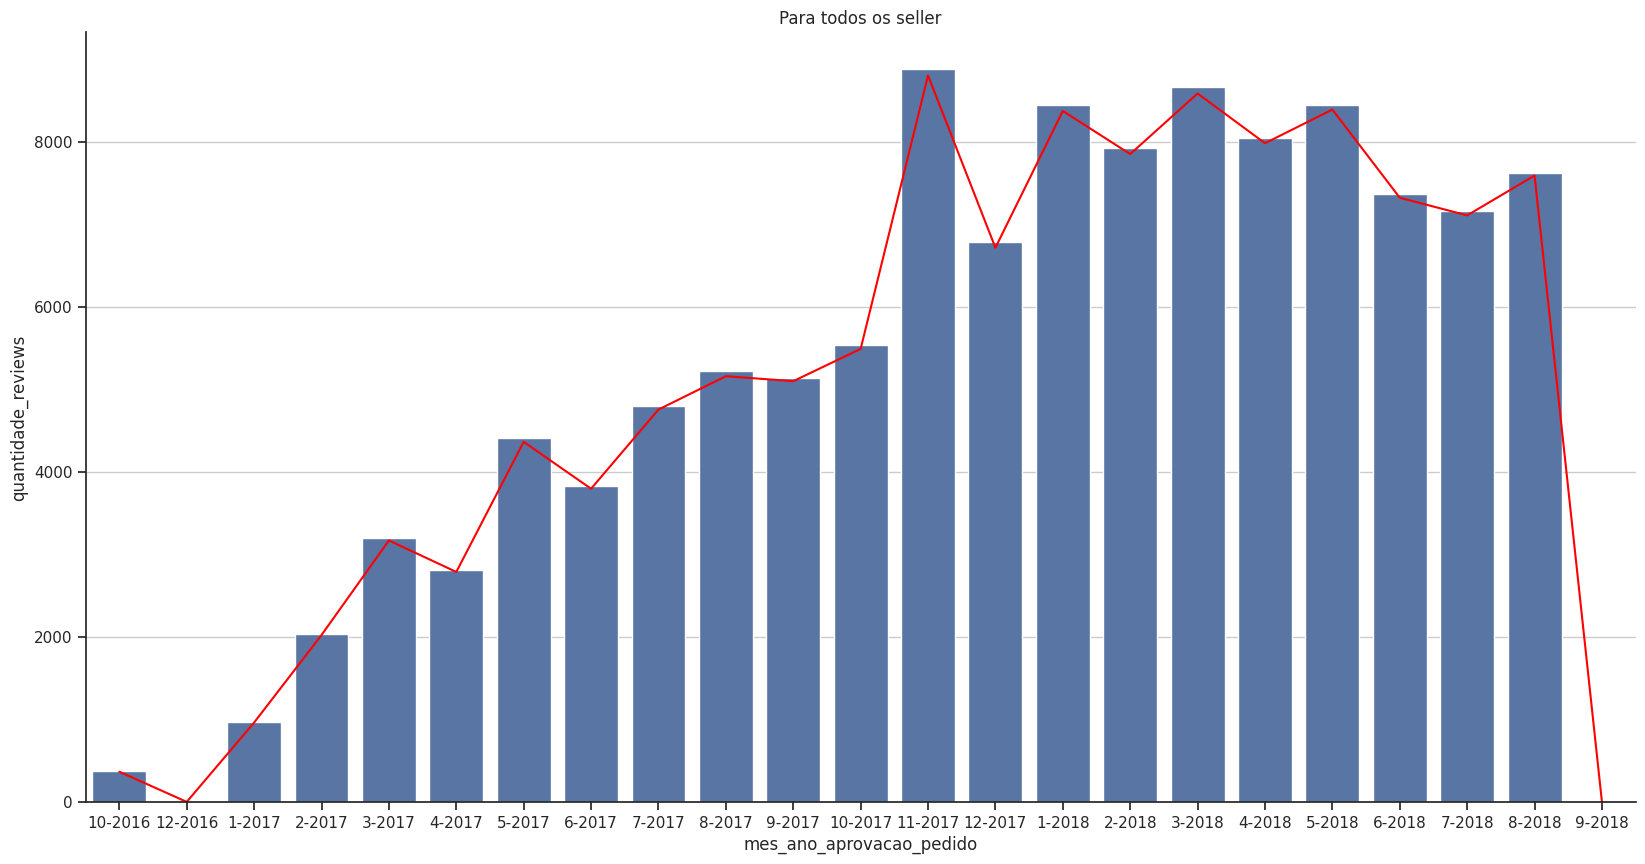

In [77]:
plt.figure(figsize=(20,10))
plt.title("Para todos os seller")
sea.lineplot(todosSeller, x='mes_ano_aprovacao_pedido', y='quantidade_reviews', color='red', markers=True, legend=True)
sea.barplot(todosSeller, x='mes_ano_aprovacao_pedido', y='quantidade_de_vendas')
plt.gca().spines[['top','right']].set_visible(False)
plt.gca().set_axisbelow(True)
plt.gca().grid(True, axis='y')
plt.show()

> Quantidade de vendas e quantidade de review tem uma grande correlação, ou seja se há muitas vendas em um mes haverá uma grande quantodade de vendas

&nbsp;

### Traga mais um insight que podemos observar no dataset mas que não foi abordado nas perguntas.

#### Será feito os top 10 customers que mais gastaram o e-commerce nos anos de 2016 a 2018 

In [78]:
query = '''
SELECT  (c.customer_id ||' - '|| c.customer_state) as Customer, 
        SUM(payment_value) AS Gastos FROM customers AS c
    INNER JOIN orders AS o_r ON
        c.customer_id = o_r.customer_id
    INNER JOIN payments AS py ON
        o_r.order_id  = py.order_id

    WHERE o_r.order_status != 'canceled'
        GROUP BY Customer
        ORDER BY 
            Gastos DESC LIMIT 10;
'''

In [79]:
data = spark.sql(query).toPandas()

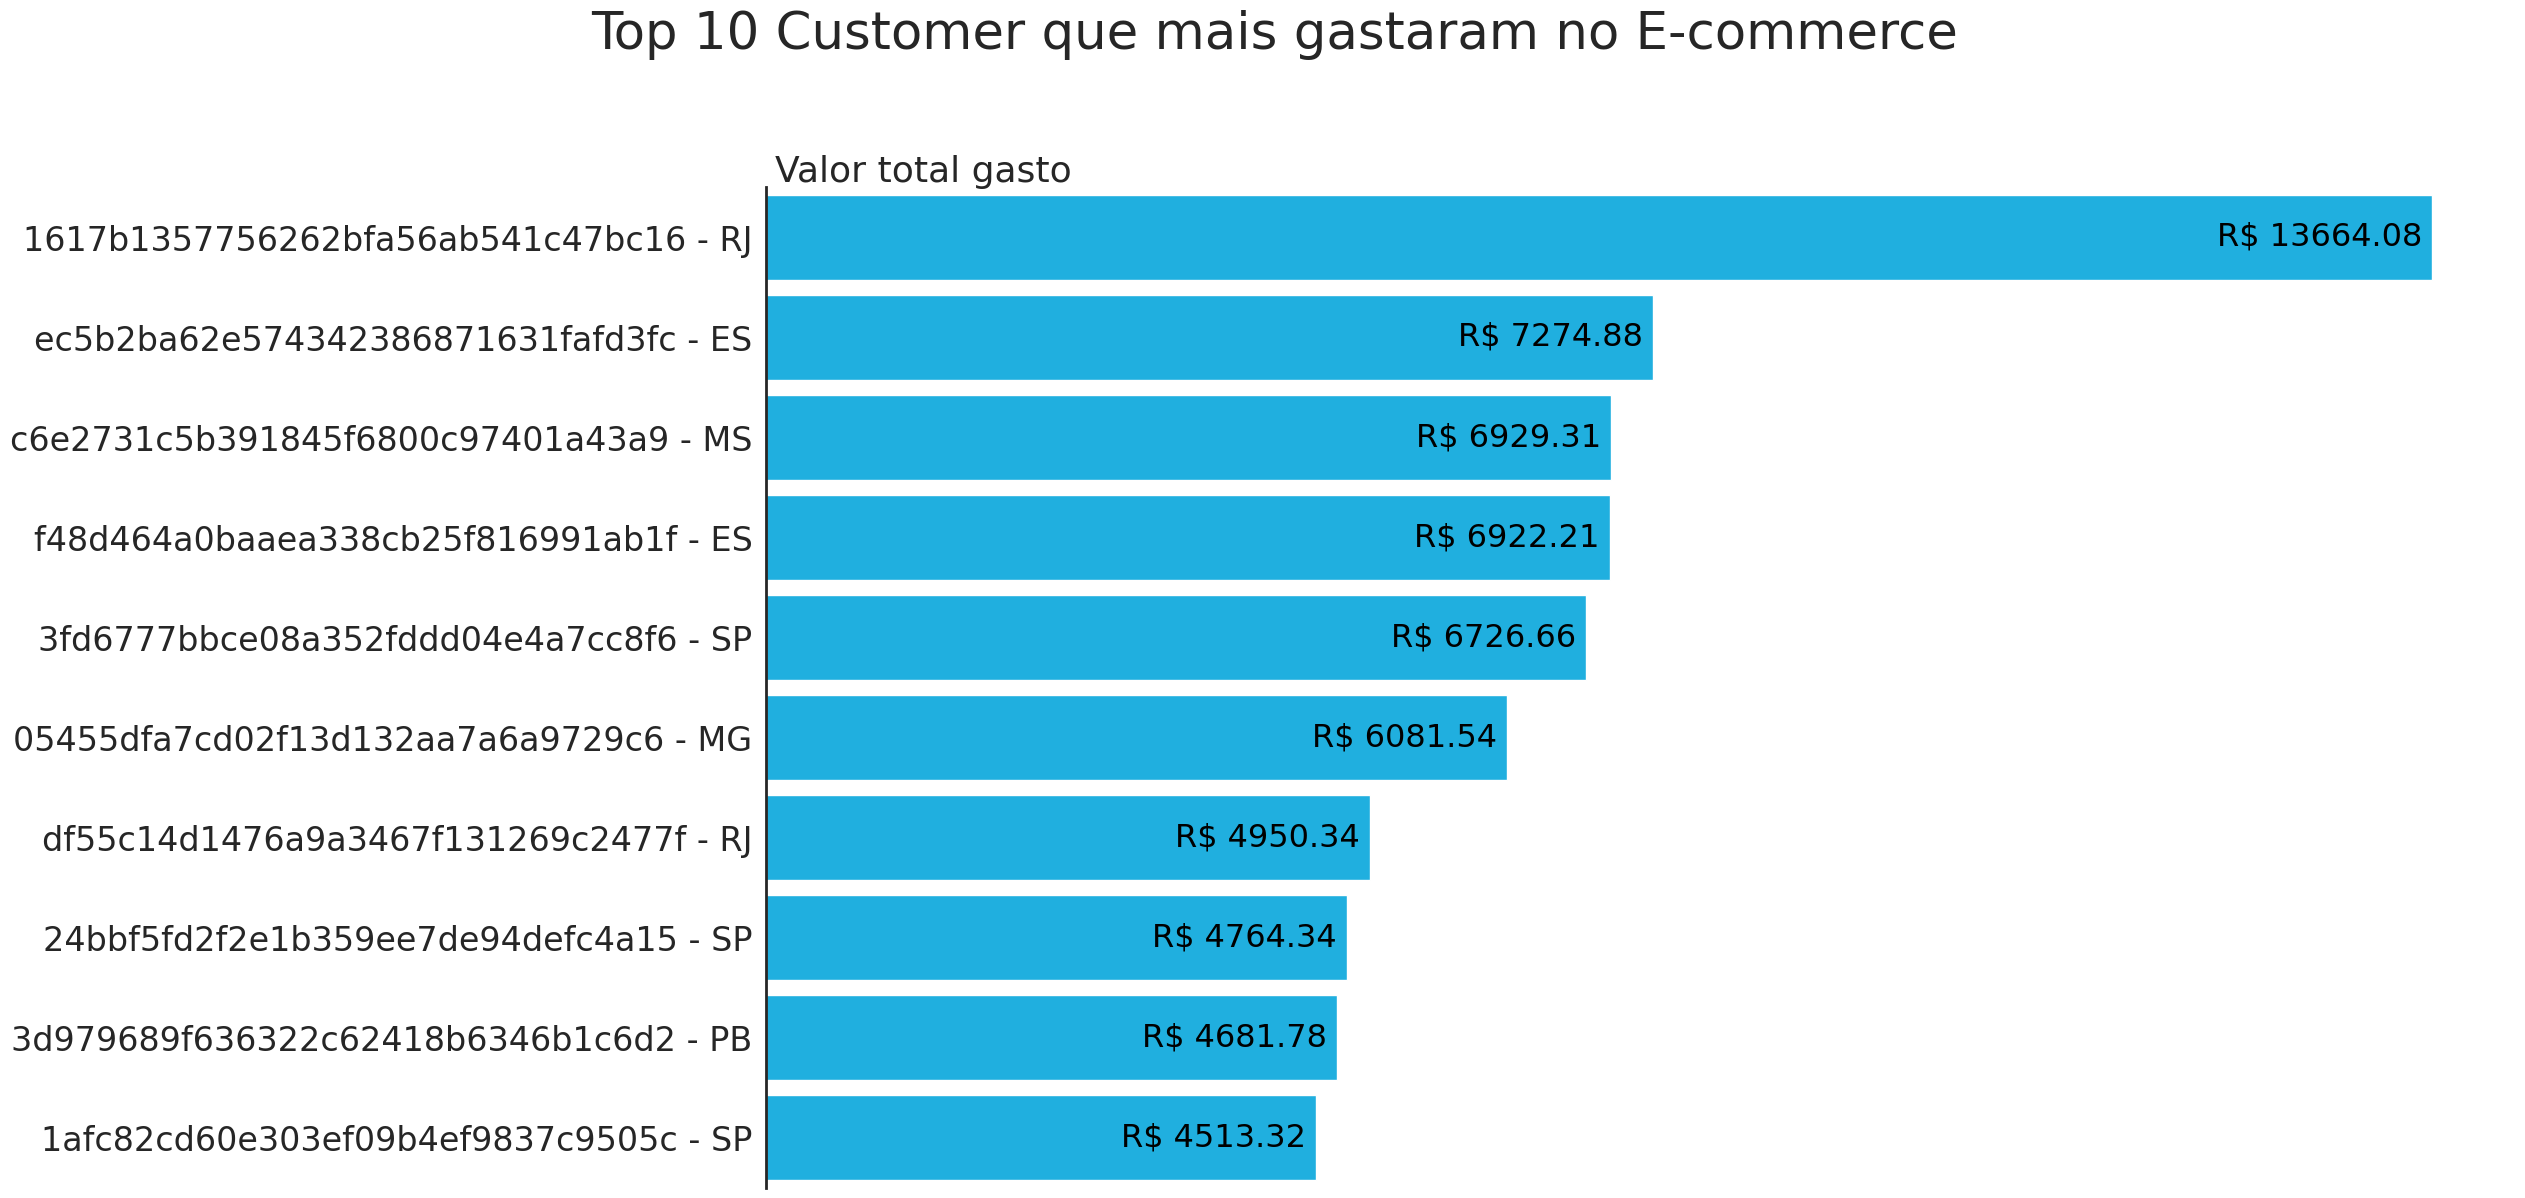

In [80]:
sea.set_theme(style='white',context='notebook')                # Definindo estilo
fig, ax = plt.subplots(ncols=1,nrows=1,figsize=(20,13))
fig.subplots_adjust(hspace=0.25,right=1)    # Aumenta o espaço entre os graficos
pallete = ['deepskyblue']*10

# Grafico 1 = Melhores receitas
barMelhores = sea.barplot( data = data, palette=pallete[::-1],
    y='Customer', x='Gastos', hue='Customer', width=0.85, ax = ax, legend=False)

#Modificando o Grafico 1
ax.set_title('Top 10 Customer que mais gastaram no E-commerce', y=1.13, fontsize=37, loc='left', x=-0.1)
ax.set_ylabel('')
ax.set_xlabel('Valor total gasto',fontsize=26, x=0.09, y=.2)
ax.spines[['right','top','bottom']].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.tick_params('y', labelsize=24)
ax.tick_params('x', bottom=False, top=False, labelbottom=False)  
ax.xaxis.set_label_position('top')
ax.set_axisbelow(True)
ax.grid(False)

# Colocando o valor das quantidade de review positiva nas barras
for p in barMelhores.patches:
    if p.get_width() != 0:
        barMelhores.annotate(("R$ %.2f" % p.get_width())+' ',  xy = (p.get_width(), p.get_y()+p.get_height()/2), 
        xytext = (0, 0.1), textcoords= 'offset points', ha = 'right', va = "center" ,size=23,color='black')